In [1]:
import numpy as np

from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Conv2D, Flatten, Dense, Conv2DTranspose, Reshape, Lambda, Activation, BatchNormalization, LeakyReLU, Dropout
from keras.models import Model
from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint 
from keras.utils import plot_model
import os
from glob import glob
from tqdm import tqdm
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf

Using TensorFlow backend.


Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
data = ["Aishwarya_Rai", "Alia_Bhatt", "Amitabh_Bachchan", "Disha_Patani", "Hrithik_Roshan", "Jacqueline_Fernandez", "Salman_Khan", "Shah_Rukh_Khan", "Shahid_Kapoor", "Shraddha_Kapoor", "Varun_Dhawan"]
d1=r'C:\Users\sushilkumar.yadav\Desktop\vmware\Personal\Research\Image_recognition_in_wild_using_Deep_Learning\standard_database\Bollywood_Training'

INPUT_DIM = (64, 64,3) # Image dimension
BATCH_SIZE = 64
Img_size = 64
Z_DIM = 200 # Dimension of the latent vector (z)
IMAGES=[]
for i in data:
    Train_dir = d1+'\\'+i+'\\'
    print(Train_dir)
    label=data.index(i)
    for img in tqdm(os.listdir(Train_dir)):
        path = os.path.join(Train_dir,img)
    #print(path,label)
        img = cv2.resize(cv2.imread(path,cv2.IMREAD_GRAYSCALE),(Img_size,Img_size))
        IMAGES.append([np.array(img),np.array(label)])

C:\Users\sushilkumar.yadav\Desktop\vmware\Personal\Research\Image_recognition_in_wild_using_Deep_Learning\standard_database\Bollywood_Training\Aishwarya_Rai\


100%|███████████████████████████████████████████████████████████████████████████████| 124/124 [00:00<00:00, 628.97it/s]


C:\Users\sushilkumar.yadav\Desktop\vmware\Personal\Research\Image_recognition_in_wild_using_Deep_Learning\standard_database\Bollywood_Training\Alia_Bhatt\


100%|███████████████████████████████████████████████████████████████████████████████| 123/123 [00:00<00:00, 601.31it/s]


C:\Users\sushilkumar.yadav\Desktop\vmware\Personal\Research\Image_recognition_in_wild_using_Deep_Learning\standard_database\Bollywood_Training\Amitabh_Bachchan\


100%|█████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 526.66it/s]


C:\Users\sushilkumar.yadav\Desktop\vmware\Personal\Research\Image_recognition_in_wild_using_Deep_Learning\standard_database\Bollywood_Training\Disha_Patani\


100%|███████████████████████████████████████████████████████████████████████████████| 111/111 [00:00<00:00, 612.61it/s]


C:\Users\sushilkumar.yadav\Desktop\vmware\Personal\Research\Image_recognition_in_wild_using_Deep_Learning\standard_database\Bollywood_Training\Hrithik_Roshan\


100%|█████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 497.55it/s]


C:\Users\sushilkumar.yadav\Desktop\vmware\Personal\Research\Image_recognition_in_wild_using_Deep_Learning\standard_database\Bollywood_Training\Jacqueline_Fernandez\


100%|███████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 533.36it/s]


C:\Users\sushilkumar.yadav\Desktop\vmware\Personal\Research\Image_recognition_in_wild_using_Deep_Learning\standard_database\Bollywood_Training\Salman_Khan\


100%|█████████████████████████████████████████████████████████████████████████████████| 94/94 [00:00<00:00, 560.38it/s]


C:\Users\sushilkumar.yadav\Desktop\vmware\Personal\Research\Image_recognition_in_wild_using_Deep_Learning\standard_database\Bollywood_Training\Shah_Rukh_Khan\


100%|█████████████████████████████████████████████████████████████████████████████████| 95/95 [00:00<00:00, 556.89it/s]


C:\Users\sushilkumar.yadav\Desktop\vmware\Personal\Research\Image_recognition_in_wild_using_Deep_Learning\standard_database\Bollywood_Training\Shahid_Kapoor\


100%|█████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 507.79it/s]


C:\Users\sushilkumar.yadav\Desktop\vmware\Personal\Research\Image_recognition_in_wild_using_Deep_Learning\standard_database\Bollywood_Training\Shraddha_Kapoor\


100%|█████████████████████████████████████████████████████████████████████████████████| 90/90 [00:00<00:00, 554.04it/s]


C:\Users\sushilkumar.yadav\Desktop\vmware\Personal\Research\Image_recognition_in_wild_using_Deep_Learning\standard_database\Bollywood_Training\Varun_Dhawan\


100%|█████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 538.68it/s]


In [3]:
no_of_images = int(str(len(IMAGES)))
print("Total number of images: " +str(no_of_images))  

Total number of images: 1111


In [4]:
data_flow = ImageDataGenerator(rescale=1./255).flow_from_directory(d1, 
                                                                   target_size = INPUT_DIM[:2],
                                                                   batch_size = BATCH_SIZE,
                                                                   shuffle = True,
                                                                   class_mode = 'input',
                                                                   subset = 'training'
                                                                   )

Found 1111 images belonging to 11 classes.


In [5]:
# ENCODER
def vae_encoder(input_dim, output_dim, conv_filters, conv_kernel_size, 
                  conv_strides, use_batch_norm = False, use_dropout = False):
  
  # Clear tensorflow session to reset layer index numbers to 0 for LeakyRelu, 
  # BatchNormalization and Dropout.
  # Otherwise, the names of above mentioned layers in the model 
  # would be inconsistent
  global K
  K.clear_session()
  
  # Number of Conv layers
  n_layers = len(conv_filters)

  # Define model input
  encoder_input = Input(shape = input_dim, name = 'encoder_input')
  x = encoder_input

  # Add convolutional layers
  for i in range(n_layers):
      x = Conv2D(filters = conv_filters[i], 
                  kernel_size = conv_kernel_size[i],
                  strides = conv_strides[i], 
                  padding = 'same',
                  name = 'encoder_conv_' + str(i)
                  )(x)
      if use_batch_norm:
        x = BatchNormalization()(x)
  
      x = LeakyReLU()(x)

      if use_dropout:
        x = Dropout(rate=0.25)(x)

  # Required for reshaping latent vector while building Decoder
  shape_before_flattening = K.int_shape(x)[1:] 
  
  x = Flatten()(x)
  
  z_mean = Dense(output_dim, name = 'mu')(x)
  z_log_var = Dense(output_dim, name = 'z_log_var')(x)

  # Defining a function for sampling
  def sampling(args):
    z_mean, z_z_log_var = args
    epsilon = K.random_normal(shape=K.shape(z_mean), mean=0., stddev=1.) 
    return z_mean + K.exp(z_z_log_var/2)*epsilon   
  
  # Using a Keras Lambda Layer to include the sampling function as a layer 
  # in the model
  encoder_output = Lambda(sampling, name='encoder_output')([z_mean, z_log_var])

  return encoder_input, encoder_output, z_mean, z_log_var, shape_before_flattening, Model(encoder_input, encoder_output)


In [6]:
vae_encoder_input, vae_encoder_output,  z_mean, z_log_var, vae_shape_before_flattening, vae_encoder  = vae_encoder(input_dim = INPUT_DIM,
                                    output_dim = Z_DIM, 
                                    conv_filters = [32, 64, 64, 64],
                                    conv_kernel_size = [3,3,3,3],
                                    conv_strides = [2,2,2,2])
vae_encoder.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
encoder_conv_0 (Conv2D)         (None, 32, 32, 32)   896         encoder_input[0][0]              
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 32, 32, 32)   0           encoder_conv_0[0][0]             
__________________________________________________________________________________________________
encoder_conv_1 (Conv2D)         (None, 16, 16, 64)   18496       leaky_re_lu_1[0][0]              
__________________________________________________________________________________________________
leaky_re_l

In [7]:
# Decoder
def vae_decoder(input_dim, shape_before_flattening, conv_filters, conv_kernel_size, 
                  conv_strides):

  # Number of Conv layers
  n_layers = len(conv_filters)

  # Define model input
  vae_decoder_input = Input(shape = (input_dim,) , name = 'vae_decoder_input')

  # To get an exact mirror image of the encoder
  x = Dense(np.prod(shape_before_flattening))(vae_decoder_input)
  x = Reshape(shape_before_flattening)(x)

  # Add convolutional layers
  for i in range(n_layers):
      x = Conv2DTranspose(filters = conv_filters[i], 
                  kernel_size = conv_kernel_size[i],
                  strides = conv_strides[i], 
                  padding = 'same',
                  name = 'decoder_conv_' + str(i)
                  )(x)
      
      # Adding a sigmoid layer at the end to restrict the outputs 
      # between 0 and 1
      if i < n_layers - 1:
        x = LeakyReLU()(x)
      else:
        x = Activation('sigmoid')(x)

  # Define model output
  vae_decoder_output = x

  return vae_decoder_input, vae_decoder_output, Model(vae_decoder_input, vae_decoder_output)

In [8]:
vae_decoder_input, vae_decoder_output, vae_decoder = vae_decoder(input_dim = Z_DIM,
                                        shape_before_flattening = vae_shape_before_flattening,
                                        conv_filters = [64,64,32,3],
                                        conv_kernel_size = [3,3,3,3],
                                        conv_strides = [2,2,2,2]
                                        )
vae_decoder.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vae_decoder_input (InputLaye (None, 200)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              205824    
_________________________________________________________________
reshape_1 (Reshape)          (None, 4, 4, 64)          0         
_________________________________________________________________
decoder_conv_0 (Conv2DTransp (None, 8, 8, 64)          36928     
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 8, 8, 64)          0         
_________________________________________________________________
decoder_conv_1 (Conv2DTransp (None, 16, 16, 64)        36928     
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 16, 16, 64)        0         
__________

In [9]:
# The input to the model will be the image fed to the encoder.
vae_input = vae_encoder_input

# Output will be the output of the decoder. The term - decoder(encoder_output) 
# combines the model by passing the encoder output to the input of the decoder.
vae_output = vae_decoder(vae_encoder_output)

# Input to the combined model will be the input to the encoder.
# Output of the combined model will be the output of the decoder.
vae_model = Model(vae_input, vae_output)

vae_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
encoder_conv_0 (Conv2D)         (None, 32, 32, 32)   896         encoder_input[0][0]              
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 32, 32, 32)   0           encoder_conv_0[0][0]             
__________________________________________________________________________________________________
encoder_conv_1 (Conv2D)         (None, 16, 16, 64)   18496       leaky_re_lu_1[0][0]              
__________________________________________________________________________________________________
leaky_re_l

In [10]:
LEARNING_RATE = 0.0005
N_EPOCHS = 300
LOSS_FACTOR = 10000

In [11]:
def kl_loss(y_true, y_pred):
    kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    return kl_loss

def reconstruction_loss(y_true, y_pred):
    return K.mean(K.square(y_true - y_pred), axis = [1,2,3])

def compute_kernel(x, y):
    x_size = tf.shape(x)[0]
    y_size = tf.shape(y)[0]
    dim = tf.shape(x)[1]
    tiled_x = tf.tile(tf.reshape(x, tf.stack([x_size, 1, dim])), tf.stack([1, y_size, 1]))
    tiled_y = tf.tile(tf.reshape(y, tf.stack([1, y_size, dim])), tf.stack([x_size, 1, 1]))
    return tf.exp(-tf.reduce_mean(tf.square(tiled_x - tiled_y), axis=2) / tf.cast(dim, tf.float32))

def compute_mmd(x, y, sigma_sqr=1.0):
    x_kernel = compute_kernel(x, x)
    y_kernel = compute_kernel(y, y)
    xy_kernel = compute_kernel(x, y)
    return tf.reduce_mean(x_kernel) + tf.reduce_mean(y_kernel) - 2 * tf.reduce_mean(xy_kernel)

def compute_mcd(x, y, sigma_sqr=1.0):
    x_kernel = compute_kernel(x, x)
    y_kernel = compute_kernel(y, y)
    xy_kernel = compute_kernel(x, y)
    yx_kernel = compute_kernel(y, x)
    squared_x_kernel = tf.square(x_kernel)
    squared_y_kernel = tf.square(y_kernel)
    squared_xy_kernel = tf.square(xy_kernel)
    #squared_yx_kernel = tf.square(yx_kernel)
    return (tf.reduce_mean(squared_x_kernel) - 2 * tf.reduce_mean(tf.square(tf.reduce_mean(x_kernel)))
                + tf.square(tf.reduce_mean(x_kernel)) - 2 * tf.reduce_mean(tf.square(squared_xy_kernel))
                + 2 * tf.reduce_mean(tf.square(tf.reduce_mean(xy_kernel)))
                + 2 * tf.reduce_mean(tf.square(tf.reduce_mean(yx_kernel)))
                - 2 * tf.square(tf.reduce_mean(xy_kernel)) + tf.reduce_mean(squared_y_kernel)
                - 2 * tf.reduce_mean(tf.square(tf.reduce_mean(y_kernel)))
                + tf.square(tf.reduce_mean(y_kernel)))
 
true_samples = tf.random_normal(tf.stack([200, Z_DIM]))
loss_mmd = compute_mmd(true_samples, vae_encoder_output)

loss_mcd = compute_mcd(true_samples, vae_encoder_output)
beta = 10  #ideal value of beta should be in between 0.001<beta<10. it is one of the hyperparameters which needs to be tuned
loss_mmcd = tf.square(loss_mmd) + beta * tf.square(loss_mcd)

def total_loss(y_true, y_pred):
    return LOSS_FACTOR*reconstruction_loss(y_true, y_pred) + loss_mmd
    #return LOSS_FACTOR*r_loss(y_true, y_pred) + kl_loss(y_true, y_pred)
    #return LOSS_FACTOR*reconstruction_loss(y_true, y_pred) + loss_mmcd
    
adam_optimizer = Adam(lr = LEARNING_RATE)

vae_model.compile(optimizer=adam_optimizer, loss = total_loss, metrics = [reconstruction_loss, kl_loss])

checkpoint_vae = ModelCheckpoint(os.path.join(r'C:\Users\sushilkumar.yadav\Desktop\vmware\Personal\Research\Image_recognition_in_wild_using_Deep_Learning\Database_FR\VAE\weightsmmd.h5'), save_weights_only = True, verbose=1)


In [12]:
vae_model.fit_generator(data_flow, 
                        shuffle=True, 
                        epochs = N_EPOCHS, 
                        initial_epoch = 0, 
                        steps_per_epoch=no_of_images / BATCH_SIZE,
                        callbacks=[checkpoint_vae])


Epoch 1/300
18/17 [===============================]- ETA: 43s - loss: 823.9260 - reconstruction_loss: 0.0824 - kl_loss: 0.24 - ETA: 23s - loss: 818.4503 - reconstruction_loss: 0.0818 - kl_loss: 0.30 - ETA: 16s - loss: 824.1136 - reconstruction_loss: 0.0824 - kl_loss: 0.47 - ETA: 12s - loss: 807.7467 - reconstruction_loss: 0.0808 - kl_loss: 0.83 - ETA: 10s - loss: 807.6238 - reconstruction_loss: 0.0808 - kl_loss: 1.44 - ETA: 8s - loss: 819.8719 - reconstruction_loss: 0.0820 - kl_loss: 2.5848 - ETA: 7s - loss: 823.4250 - reconstruction_loss: 0.0823 - kl_loss: 4.263 - ETA: 6s - loss: 822.2982 - reconstruction_loss: 0.0822 - kl_loss: 7.536 - ETA: 5s - loss: 822.6049 - reconstruction_loss: 0.0823 - kl_loss: 12.62 - ETA: 4s - loss: 821.1117 - reconstruction_loss: 0.0821 - kl_loss: 21.79 - ETA: 3s - loss: 819.5514 - reconstruction_loss: 0.0820 - kl_loss: 38.12 - ETA: 3s - loss: 819.0398 - reconstruction_loss: 0.0819 - kl_loss: 68.37 - ETA: 2s - loss: 817.3548 - reconstruction_loss: 0.0817 - k

18/17 [===============================]- ETA: 6s - loss: 231.7077 - reconstruction_loss: 0.0232 - kl_loss: 842.635 - ETA: 6s - loss: 231.7677 - reconstruction_loss: 0.0232 - kl_loss: 832.455 - ETA: 5s - loss: 229.6836 - reconstruction_loss: 0.0230 - kl_loss: 852.161 - ETA: 5s - loss: 225.3721 - reconstruction_loss: 0.0225 - kl_loss: 859.925 - ETA: 4s - loss: 224.5968 - reconstruction_loss: 0.0225 - kl_loss: 840.690 - ETA: 4s - loss: 224.3668 - reconstruction_loss: 0.0224 - kl_loss: 836.215 - ETA: 3s - loss: 223.6859 - reconstruction_loss: 0.0224 - kl_loss: 826.526 - ETA: 3s - loss: 222.7936 - reconstruction_loss: 0.0223 - kl_loss: 825.431 - ETA: 3s - loss: 221.4876 - reconstruction_loss: 0.0221 - kl_loss: 822.725 - ETA: 2s - loss: 220.5800 - reconstruction_loss: 0.0221 - kl_loss: 818.391 - ETA: 2s - loss: 221.8838 - reconstruction_loss: 0.0222 - kl_loss: 811.852 - ETA: 2s - loss: 220.5221 - reconstruction_loss: 0.0221 - kl_loss: 804.787 - ETA: 1s - loss: 218.8788 - reconstruction_loss:

18/17 [===============================]- ETA: 6s - loss: 141.8820 - reconstruction_loss: 0.0142 - kl_loss: 1153.26 - ETA: 6s - loss: 145.7560 - reconstruction_loss: 0.0146 - kl_loss: 1141.09 - ETA: 5s - loss: 150.3421 - reconstruction_loss: 0.0150 - kl_loss: 1167.97 - ETA: 5s - loss: 151.5548 - reconstruction_loss: 0.0152 - kl_loss: 1181.62 - ETA: 5s - loss: 154.6135 - reconstruction_loss: 0.0155 - kl_loss: 1179.39 - ETA: 4s - loss: 153.0497 - reconstruction_loss: 0.0153 - kl_loss: 1176.24 - ETA: 4s - loss: 152.5055 - reconstruction_loss: 0.0152 - kl_loss: 1171.36 - ETA: 3s - loss: 152.1505 - reconstruction_loss: 0.0152 - kl_loss: 1174.47 - ETA: 3s - loss: 151.4944 - reconstruction_loss: 0.0151 - kl_loss: 1171.14 - ETA: 3s - loss: 151.8237 - reconstruction_loss: 0.0152 - kl_loss: 1182.33 - ETA: 2s - loss: 151.6376 - reconstruction_loss: 0.0152 - kl_loss: 1186.30 - ETA: 2s - loss: 151.7353 - reconstruction_loss: 0.0152 - kl_loss: 1176.43 - ETA: 1s - loss: 152.1924 - reconstruction_loss:

18/17 [===============================]- ETA: 6s - loss: 128.5512 - reconstruction_loss: 0.0129 - kl_loss: 1286.93 - ETA: 6s - loss: 129.9980 - reconstruction_loss: 0.0130 - kl_loss: 1303.54 - ETA: 5s - loss: 130.3776 - reconstruction_loss: 0.0130 - kl_loss: 1312.47 - ETA: 5s - loss: 129.0518 - reconstruction_loss: 0.0129 - kl_loss: 1302.83 - ETA: 4s - loss: 129.2967 - reconstruction_loss: 0.0129 - kl_loss: 1306.13 - ETA: 4s - loss: 128.8821 - reconstruction_loss: 0.0129 - kl_loss: 1302.53 - ETA: 4s - loss: 130.0962 - reconstruction_loss: 0.0130 - kl_loss: 1302.56 - ETA: 3s - loss: 130.3348 - reconstruction_loss: 0.0130 - kl_loss: 1312.51 - ETA: 3s - loss: 130.0266 - reconstruction_loss: 0.0130 - kl_loss: 1311.31 - ETA: 2s - loss: 130.2623 - reconstruction_loss: 0.0130 - kl_loss: 1305.75 - ETA: 2s - loss: 131.0583 - reconstruction_loss: 0.0131 - kl_loss: 1300.28 - ETA: 2s - loss: 131.9250 - reconstruction_loss: 0.0132 - kl_loss: 1309.13 - ETA: 1s - loss: 131.8484 - reconstruction_loss:

18/17 [===============================]- ETA: 6s - loss: 115.3993 - reconstruction_loss: 0.0115 - kl_loss: 1385.47 - ETA: 6s - loss: 116.0969 - reconstruction_loss: 0.0116 - kl_loss: 1358.50 - ETA: 5s - loss: 119.0106 - reconstruction_loss: 0.0119 - kl_loss: 1346.29 - ETA: 5s - loss: 119.4711 - reconstruction_loss: 0.0119 - kl_loss: 1382.06 - ETA: 4s - loss: 119.3248 - reconstruction_loss: 0.0119 - kl_loss: 1386.13 - ETA: 4s - loss: 118.7134 - reconstruction_loss: 0.0119 - kl_loss: 1381.54 - ETA: 4s - loss: 118.5365 - reconstruction_loss: 0.0119 - kl_loss: 1388.10 - ETA: 3s - loss: 118.0078 - reconstruction_loss: 0.0118 - kl_loss: 1387.86 - ETA: 3s - loss: 118.1586 - reconstruction_loss: 0.0118 - kl_loss: 1389.38 - ETA: 3s - loss: 118.4299 - reconstruction_loss: 0.0118 - kl_loss: 1388.81 - ETA: 2s - loss: 118.9231 - reconstruction_loss: 0.0119 - kl_loss: 1383.04 - ETA: 2s - loss: 118.0430 - reconstruction_loss: 0.0118 - kl_loss: 1376.64 - ETA: 1s - loss: 118.1953 - reconstruction_loss:

18/17 [===============================]- ETA: 6s - loss: 104.7467 - reconstruction_loss: 0.0105 - kl_loss: 1421.40 - ETA: 6s - loss: 102.2332 - reconstruction_loss: 0.0102 - kl_loss: 1400.47 - ETA: 5s - loss: 104.7841 - reconstruction_loss: 0.0105 - kl_loss: 1418.55 - ETA: 5s - loss: 107.3014 - reconstruction_loss: 0.0107 - kl_loss: 1432.63 - ETA: 5s - loss: 106.5751 - reconstruction_loss: 0.0107 - kl_loss: 1433.32 - ETA: 4s - loss: 106.9500 - reconstruction_loss: 0.0107 - kl_loss: 1436.85 - ETA: 4s - loss: 106.0806 - reconstruction_loss: 0.0106 - kl_loss: 1433.68 - ETA: 3s - loss: 106.4413 - reconstruction_loss: 0.0106 - kl_loss: 1435.57 - ETA: 3s - loss: 106.2349 - reconstruction_loss: 0.0106 - kl_loss: 1432.47 - ETA: 3s - loss: 106.5021 - reconstruction_loss: 0.0106 - kl_loss: 1440.29 - ETA: 2s - loss: 105.9573 - reconstruction_loss: 0.0106 - kl_loss: 1440.07 - ETA: 2s - loss: 106.4961 - reconstruction_loss: 0.0106 - kl_loss: 1438.77 - ETA: 1s - loss: 107.4630 - reconstruction_loss:

18/17 [===============================]- ETA: 7s - loss: 96.9998 - reconstruction_loss: 0.0097 - kl_loss: 1500.618 - ETA: 6s - loss: 99.7911 - reconstruction_loss: 0.0100 - kl_loss: 1496.606 - ETA: 5s - loss: 100.2438 - reconstruction_loss: 0.0100 - kl_loss: 1529.85 - ETA: 5s - loss: 100.6746 - reconstruction_loss: 0.0101 - kl_loss: 1507.94 - ETA: 5s - loss: 102.0041 - reconstruction_loss: 0.0102 - kl_loss: 1523.12 - ETA: 4s - loss: 102.4818 - reconstruction_loss: 0.0102 - kl_loss: 1516.52 - ETA: 4s - loss: 101.3876 - reconstruction_loss: 0.0101 - kl_loss: 1518.17 - ETA: 3s - loss: 100.7446 - reconstruction_loss: 0.0101 - kl_loss: 1507.31 - ETA: 3s - loss: 101.1463 - reconstruction_loss: 0.0101 - kl_loss: 1502.99 - ETA: 3s - loss: 102.4360 - reconstruction_loss: 0.0102 - kl_loss: 1508.47 - ETA: 2s - loss: 102.7523 - reconstruction_loss: 0.0103 - kl_loss: 1511.47 - ETA: 2s - loss: 102.3500 - reconstruction_loss: 0.0102 - kl_loss: 1506.87 - ETA: 1s - loss: 102.6972 - reconstruction_loss:

18/17 [===============================]- ETA: 5s - loss: 90.3306 - reconstruction_loss: 0.0090 - kl_loss: 1528.252 - ETA: 4s - loss: 97.9173 - reconstruction_loss: 0.0098 - kl_loss: 1520.834 - ETA: 4s - loss: 97.4523 - reconstruction_loss: 0.0097 - kl_loss: 1519.028 - ETA: 4s - loss: 98.2487 - reconstruction_loss: 0.0098 - kl_loss: 1536.587 - ETA: 3s - loss: 96.2866 - reconstruction_loss: 0.0096 - kl_loss: 1540.947 - ETA: 3s - loss: 96.9712 - reconstruction_loss: 0.0097 - kl_loss: 1548.154 - ETA: 3s - loss: 97.6075 - reconstruction_loss: 0.0098 - kl_loss: 1547.854 - ETA: 2s - loss: 97.5949 - reconstruction_loss: 0.0098 - kl_loss: 1544.855 - ETA: 2s - loss: 96.9138 - reconstruction_loss: 0.0097 - kl_loss: 1541.749 - ETA: 2s - loss: 96.6399 - reconstruction_loss: 0.0097 - kl_loss: 1543.521 - ETA: 1s - loss: 96.9213 - reconstruction_loss: 0.0097 - kl_loss: 1543.395 - ETA: 1s - loss: 96.4263 - reconstruction_loss: 0.0096 - kl_loss: 1542.238 - ETA: 1s - loss: 96.1879 - reconstruction_loss: 

18/17 [===============================]- ETA: 6s - loss: 93.3039 - reconstruction_loss: 0.0093 - kl_loss: 1664.993 - ETA: 5s - loss: 91.5401 - reconstruction_loss: 0.0092 - kl_loss: 1636.825 - ETA: 4s - loss: 88.8437 - reconstruction_loss: 0.0089 - kl_loss: 1604.147 - ETA: 4s - loss: 88.6042 - reconstruction_loss: 0.0089 - kl_loss: 1602.340 - ETA: 4s - loss: 87.9177 - reconstruction_loss: 0.0088 - kl_loss: 1588.691 - ETA: 3s - loss: 88.3497 - reconstruction_loss: 0.0088 - kl_loss: 1588.793 - ETA: 3s - loss: 89.1356 - reconstruction_loss: 0.0089 - kl_loss: 1587.428 - ETA: 2s - loss: 89.1530 - reconstruction_loss: 0.0089 - kl_loss: 1588.305 - ETA: 2s - loss: 89.5439 - reconstruction_loss: 0.0090 - kl_loss: 1586.726 - ETA: 2s - loss: 90.5735 - reconstruction_loss: 0.0091 - kl_loss: 1589.025 - ETA: 1s - loss: 91.3259 - reconstruction_loss: 0.0091 - kl_loss: 1586.695 - ETA: 1s - loss: 92.0455 - reconstruction_loss: 0.0092 - kl_loss: 1591.175 - ETA: 1s - loss: 92.6074 - reconstruction_loss: 

18/17 [===============================]- ETA: 4s - loss: 88.7256 - reconstruction_loss: 0.0089 - kl_loss: 1676.981 - ETA: 4s - loss: 88.9197 - reconstruction_loss: 0.0089 - kl_loss: 1680.555 - ETA: 4s - loss: 87.9900 - reconstruction_loss: 0.0088 - kl_loss: 1681.200 - ETA: 4s - loss: 87.0116 - reconstruction_loss: 0.0087 - kl_loss: 1681.028 - ETA: 3s - loss: 87.3443 - reconstruction_loss: 0.0087 - kl_loss: 1678.430 - ETA: 3s - loss: 88.0695 - reconstruction_loss: 0.0088 - kl_loss: 1681.491 - ETA: 3s - loss: 87.6460 - reconstruction_loss: 0.0088 - kl_loss: 1674.374 - ETA: 2s - loss: 87.4764 - reconstruction_loss: 0.0087 - kl_loss: 1679.474 - ETA: 2s - loss: 87.4866 - reconstruction_loss: 0.0087 - kl_loss: 1675.501 - ETA: 2s - loss: 87.2997 - reconstruction_loss: 0.0087 - kl_loss: 1677.405 - ETA: 1s - loss: 87.1039 - reconstruction_loss: 0.0087 - kl_loss: 1677.744 - ETA: 1s - loss: 87.1684 - reconstruction_loss: 0.0087 - kl_loss: 1678.558 - ETA: 1s - loss: 87.1305 - reconstruction_loss: 

18/17 [===============================]- ETA: 4s - loss: 74.9370 - reconstruction_loss: 0.0075 - kl_loss: 1683.226 - ETA: 4s - loss: 78.6171 - reconstruction_loss: 0.0079 - kl_loss: 1729.243 - ETA: 3s - loss: 81.0112 - reconstruction_loss: 0.0081 - kl_loss: 1722.181 - ETA: 3s - loss: 83.0488 - reconstruction_loss: 0.0083 - kl_loss: 1723.329 - ETA: 3s - loss: 82.7724 - reconstruction_loss: 0.0083 - kl_loss: 1737.714 - ETA: 3s - loss: 83.3875 - reconstruction_loss: 0.0083 - kl_loss: 1744.226 - ETA: 2s - loss: 82.9485 - reconstruction_loss: 0.0083 - kl_loss: 1737.073 - ETA: 2s - loss: 82.8815 - reconstruction_loss: 0.0083 - kl_loss: 1733.676 - ETA: 2s - loss: 83.2111 - reconstruction_loss: 0.0083 - kl_loss: 1739.933 - ETA: 2s - loss: 83.3995 - reconstruction_loss: 0.0083 - kl_loss: 1734.821 - ETA: 1s - loss: 82.5633 - reconstruction_loss: 0.0083 - kl_loss: 1728.061 - ETA: 1s - loss: 82.2990 - reconstruction_loss: 0.0082 - kl_loss: 1725.918 - ETA: 1s - loss: 82.2904 - reconstruction_loss: 

18/17 [===============================]- ETA: 4s - loss: 72.6128 - reconstruction_loss: 0.0073 - kl_loss: 1785.881 - ETA: 4s - loss: 72.8338 - reconstruction_loss: 0.0073 - kl_loss: 1775.764 - ETA: 4s - loss: 73.3687 - reconstruction_loss: 0.0073 - kl_loss: 1778.262 - ETA: 3s - loss: 75.5088 - reconstruction_loss: 0.0075 - kl_loss: 1777.659 - ETA: 3s - loss: 74.8915 - reconstruction_loss: 0.0075 - kl_loss: 1766.597 - ETA: 3s - loss: 74.8582 - reconstruction_loss: 0.0075 - kl_loss: 1762.466 - ETA: 3s - loss: 76.4255 - reconstruction_loss: 0.0076 - kl_loss: 1767.588 - ETA: 2s - loss: 76.8337 - reconstruction_loss: 0.0077 - kl_loss: 1772.367 - ETA: 2s - loss: 76.6466 - reconstruction_loss: 0.0077 - kl_loss: 1770.797 - ETA: 2s - loss: 76.1942 - reconstruction_loss: 0.0076 - kl_loss: 1771.399 - ETA: 1s - loss: 76.5759 - reconstruction_loss: 0.0077 - kl_loss: 1771.672 - ETA: 1s - loss: 76.7617 - reconstruction_loss: 0.0077 - kl_loss: 1773.202 - ETA: 1s - loss: 76.9609 - reconstruction_loss: 

18/17 [===============================]- ETA: 4s - loss: 76.9410 - reconstruction_loss: 0.0077 - kl_loss: 1851.602 - ETA: 4s - loss: 75.0721 - reconstruction_loss: 0.0075 - kl_loss: 1816.263 - ETA: 4s - loss: 74.8340 - reconstruction_loss: 0.0075 - kl_loss: 1815.589 - ETA: 4s - loss: 74.2075 - reconstruction_loss: 0.0074 - kl_loss: 1806.852 - ETA: 3s - loss: 73.2062 - reconstruction_loss: 0.0073 - kl_loss: 1790.959 - ETA: 3s - loss: 74.8041 - reconstruction_loss: 0.0075 - kl_loss: 1794.697 - ETA: 3s - loss: 75.5250 - reconstruction_loss: 0.0076 - kl_loss: 1800.273 - ETA: 2s - loss: 74.6784 - reconstruction_loss: 0.0075 - kl_loss: 1796.555 - ETA: 2s - loss: 74.2202 - reconstruction_loss: 0.0074 - kl_loss: 1798.959 - ETA: 2s - loss: 73.3240 - reconstruction_loss: 0.0073 - kl_loss: 1795.739 - ETA: 1s - loss: 73.5029 - reconstruction_loss: 0.0073 - kl_loss: 1796.277 - ETA: 1s - loss: 73.5541 - reconstruction_loss: 0.0074 - kl_loss: 1799.530 - ETA: 1s - loss: 73.3201 - reconstruction_loss: 

18/17 [===============================]- ETA: 5s - loss: 71.5412 - reconstruction_loss: 0.0072 - kl_loss: 1804.969 - ETA: 4s - loss: 70.3703 - reconstruction_loss: 0.0070 - kl_loss: 1831.344 - ETA: 4s - loss: 70.4820 - reconstruction_loss: 0.0070 - kl_loss: 1840.545 - ETA: 4s - loss: 70.6252 - reconstruction_loss: 0.0071 - kl_loss: 1837.533 - ETA: 4s - loss: 70.6410 - reconstruction_loss: 0.0071 - kl_loss: 1840.555 - ETA: 3s - loss: 70.9290 - reconstruction_loss: 0.0071 - kl_loss: 1841.875 - ETA: 3s - loss: 70.5670 - reconstruction_loss: 0.0071 - kl_loss: 1843.581 - ETA: 3s - loss: 70.8292 - reconstruction_loss: 0.0071 - kl_loss: 1831.603 - ETA: 2s - loss: 71.1456 - reconstruction_loss: 0.0071 - kl_loss: 1838.873 - ETA: 2s - loss: 71.2977 - reconstruction_loss: 0.0071 - kl_loss: 1839.186 - ETA: 1s - loss: 71.3404 - reconstruction_loss: 0.0071 - kl_loss: 1834.743 - ETA: 1s - loss: 71.6303 - reconstruction_loss: 0.0072 - kl_loss: 1835.079 - ETA: 1s - loss: 71.9272 - reconstruction_loss: 

18/17 [===============================]- ETA: 4s - loss: 68.9027 - reconstruction_loss: 0.0069 - kl_loss: 1857.417 - ETA: 4s - loss: 68.8891 - reconstruction_loss: 0.0069 - kl_loss: 1858.897 - ETA: 4s - loss: 69.0610 - reconstruction_loss: 0.0069 - kl_loss: 1851.492 - ETA: 3s - loss: 69.6937 - reconstruction_loss: 0.0070 - kl_loss: 1842.214 - ETA: 3s - loss: 69.4909 - reconstruction_loss: 0.0069 - kl_loss: 1846.258 - ETA: 3s - loss: 69.8410 - reconstruction_loss: 0.0070 - kl_loss: 1848.099 - ETA: 2s - loss: 70.0720 - reconstruction_loss: 0.0070 - kl_loss: 1844.703 - ETA: 2s - loss: 70.1356 - reconstruction_loss: 0.0070 - kl_loss: 1844.544 - ETA: 2s - loss: 69.8823 - reconstruction_loss: 0.0070 - kl_loss: 1848.011 - ETA: 2s - loss: 69.5720 - reconstruction_loss: 0.0070 - kl_loss: 1846.119 - ETA: 1s - loss: 69.0102 - reconstruction_loss: 0.0069 - kl_loss: 1843.151 - ETA: 1s - loss: 69.3527 - reconstruction_loss: 0.0069 - kl_loss: 1848.180 - ETA: 1s - loss: 69.1887 - reconstruction_loss: 

18/17 [===============================]- ETA: 4s - loss: 66.5229 - reconstruction_loss: 0.0067 - kl_loss: 1867.088 - ETA: 4s - loss: 68.6984 - reconstruction_loss: 0.0069 - kl_loss: 1927.934 - ETA: 4s - loss: 69.3553 - reconstruction_loss: 0.0069 - kl_loss: 1922.541 - ETA: 4s - loss: 68.9085 - reconstruction_loss: 0.0069 - kl_loss: 1914.175 - ETA: 3s - loss: 68.1077 - reconstruction_loss: 0.0068 - kl_loss: 1907.872 - ETA: 3s - loss: 66.9200 - reconstruction_loss: 0.0067 - kl_loss: 1895.232 - ETA: 3s - loss: 67.0064 - reconstruction_loss: 0.0067 - kl_loss: 1897.535 - ETA: 2s - loss: 67.1683 - reconstruction_loss: 0.0067 - kl_loss: 1900.033 - ETA: 2s - loss: 66.5665 - reconstruction_loss: 0.0067 - kl_loss: 1893.426 - ETA: 2s - loss: 66.0932 - reconstruction_loss: 0.0066 - kl_loss: 1896.145 - ETA: 1s - loss: 66.4407 - reconstruction_loss: 0.0066 - kl_loss: 1898.401 - ETA: 1s - loss: 66.7991 - reconstruction_loss: 0.0067 - kl_loss: 1900.353 - ETA: 1s - loss: 66.7750 - reconstruction_loss: 

18/17 [===============================]- ETA: 4s - loss: 58.4994 - reconstruction_loss: 0.0058 - kl_loss: 1931.845 - ETA: 4s - loss: 60.9812 - reconstruction_loss: 0.0061 - kl_loss: 1946.779 - ETA: 4s - loss: 63.2798 - reconstruction_loss: 0.0063 - kl_loss: 1945.279 - ETA: 4s - loss: 63.6318 - reconstruction_loss: 0.0064 - kl_loss: 1952.925 - ETA: 3s - loss: 63.4667 - reconstruction_loss: 0.0063 - kl_loss: 1953.828 - ETA: 3s - loss: 64.0667 - reconstruction_loss: 0.0064 - kl_loss: 1949.752 - ETA: 2s - loss: 63.9746 - reconstruction_loss: 0.0064 - kl_loss: 1938.308 - ETA: 2s - loss: 63.9437 - reconstruction_loss: 0.0064 - kl_loss: 1928.778 - ETA: 2s - loss: 63.8405 - reconstruction_loss: 0.0064 - kl_loss: 1924.608 - ETA: 2s - loss: 64.6949 - reconstruction_loss: 0.0065 - kl_loss: 1926.828 - ETA: 1s - loss: 64.0119 - reconstruction_loss: 0.0064 - kl_loss: 1921.609 - ETA: 1s - loss: 64.1460 - reconstruction_loss: 0.0064 - kl_loss: 1924.663 - ETA: 1s - loss: 63.7739 - reconstruction_loss: 

18/17 [===============================]- ETA: 4s - loss: 57.7701 - reconstruction_loss: 0.0058 - kl_loss: 1892.276 - ETA: 4s - loss: 60.6196 - reconstruction_loss: 0.0061 - kl_loss: 1927.659 - ETA: 4s - loss: 62.4177 - reconstruction_loss: 0.0062 - kl_loss: 1941.998 - ETA: 4s - loss: 61.5445 - reconstruction_loss: 0.0062 - kl_loss: 1940.635 - ETA: 3s - loss: 61.0097 - reconstruction_loss: 0.0061 - kl_loss: 1942.537 - ETA: 3s - loss: 61.4256 - reconstruction_loss: 0.0061 - kl_loss: 1945.090 - ETA: 2s - loss: 61.3351 - reconstruction_loss: 0.0061 - kl_loss: 1939.275 - ETA: 2s - loss: 62.1777 - reconstruction_loss: 0.0062 - kl_loss: 1941.369 - ETA: 2s - loss: 62.5602 - reconstruction_loss: 0.0063 - kl_loss: 1945.761 - ETA: 2s - loss: 62.8233 - reconstruction_loss: 0.0063 - kl_loss: 1946.285 - ETA: 1s - loss: 62.9432 - reconstruction_loss: 0.0063 - kl_loss: 1945.539 - ETA: 1s - loss: 62.9477 - reconstruction_loss: 0.0063 - kl_loss: 1952.048 - ETA: 1s - loss: 63.4345 - reconstruction_loss: 

18/17 [===============================]- ETA: 5s - loss: 61.5816 - reconstruction_loss: 0.0062 - kl_loss: 1981.248 - ETA: 4s - loss: 62.7590 - reconstruction_loss: 0.0063 - kl_loss: 2014.015 - ETA: 4s - loss: 61.0656 - reconstruction_loss: 0.0061 - kl_loss: 2015.850 - ETA: 4s - loss: 59.9923 - reconstruction_loss: 0.0060 - kl_loss: 1984.318 - ETA: 3s - loss: 60.3018 - reconstruction_loss: 0.0060 - kl_loss: 1997.716 - ETA: 3s - loss: 60.4821 - reconstruction_loss: 0.0060 - kl_loss: 2000.401 - ETA: 3s - loss: 59.8022 - reconstruction_loss: 0.0060 - kl_loss: 2002.347 - ETA: 2s - loss: 60.2671 - reconstruction_loss: 0.0060 - kl_loss: 2002.700 - ETA: 2s - loss: 60.7824 - reconstruction_loss: 0.0061 - kl_loss: 2007.406 - ETA: 2s - loss: 61.5631 - reconstruction_loss: 0.0062 - kl_loss: 2007.994 - ETA: 1s - loss: 61.5234 - reconstruction_loss: 0.0062 - kl_loss: 2011.179 - ETA: 1s - loss: 61.6696 - reconstruction_loss: 0.0062 - kl_loss: 2011.045 - ETA: 1s - loss: 61.5902 - reconstruction_loss: 

18/17 [===============================]- ETA: 5s - loss: 59.3643 - reconstruction_loss: 0.0059 - kl_loss: 2051.932 - ETA: 4s - loss: 61.6362 - reconstruction_loss: 0.0062 - kl_loss: 2060.088 - ETA: 4s - loss: 60.8690 - reconstruction_loss: 0.0061 - kl_loss: 2032.761 - ETA: 4s - loss: 59.9797 - reconstruction_loss: 0.0060 - kl_loss: 2039.052 - ETA: 3s - loss: 59.0539 - reconstruction_loss: 0.0059 - kl_loss: 2021.090 - ETA: 3s - loss: 59.4597 - reconstruction_loss: 0.0059 - kl_loss: 2027.020 - ETA: 2s - loss: 59.6099 - reconstruction_loss: 0.0060 - kl_loss: 2029.427 - ETA: 2s - loss: 59.1655 - reconstruction_loss: 0.0059 - kl_loss: 2025.081 - ETA: 2s - loss: 58.9138 - reconstruction_loss: 0.0059 - kl_loss: 2024.487 - ETA: 2s - loss: 58.7935 - reconstruction_loss: 0.0059 - kl_loss: 2016.721 - ETA: 1s - loss: 58.3343 - reconstruction_loss: 0.0058 - kl_loss: 2018.391 - ETA: 1s - loss: 58.2469 - reconstruction_loss: 0.0058 - kl_loss: 2018.762 - ETA: 1s - loss: 58.5116 - reconstruction_loss: 

18/17 [===============================]- ETA: 4s - loss: 56.0695 - reconstruction_loss: 0.0056 - kl_loss: 2078.221 - ETA: 4s - loss: 55.0342 - reconstruction_loss: 0.0055 - kl_loss: 2048.404 - ETA: 4s - loss: 56.9865 - reconstruction_loss: 0.0057 - kl_loss: 2039.360 - ETA: 3s - loss: 57.7728 - reconstruction_loss: 0.0058 - kl_loss: 2049.867 - ETA: 3s - loss: 58.0062 - reconstruction_loss: 0.0058 - kl_loss: 2056.869 - ETA: 3s - loss: 57.7996 - reconstruction_loss: 0.0058 - kl_loss: 2064.679 - ETA: 2s - loss: 57.3787 - reconstruction_loss: 0.0057 - kl_loss: 2059.737 - ETA: 2s - loss: 57.9290 - reconstruction_loss: 0.0058 - kl_loss: 2069.654 - ETA: 2s - loss: 57.6525 - reconstruction_loss: 0.0058 - kl_loss: 2070.815 - ETA: 2s - loss: 57.8911 - reconstruction_loss: 0.0058 - kl_loss: 2077.249 - ETA: 1s - loss: 58.0227 - reconstruction_loss: 0.0058 - kl_loss: 2082.066 - ETA: 1s - loss: 58.0012 - reconstruction_loss: 0.0058 - kl_loss: 2079.728 - ETA: 1s - loss: 58.3518 - reconstruction_loss: 

18/17 [===============================]- ETA: 5s - loss: 59.2462 - reconstruction_loss: 0.0059 - kl_loss: 2148.757 - ETA: 4s - loss: 58.5908 - reconstruction_loss: 0.0059 - kl_loss: 2110.836 - ETA: 4s - loss: 57.9262 - reconstruction_loss: 0.0058 - kl_loss: 2104.269 - ETA: 4s - loss: 57.4487 - reconstruction_loss: 0.0057 - kl_loss: 2098.753 - ETA: 3s - loss: 56.6666 - reconstruction_loss: 0.0057 - kl_loss: 2109.255 - ETA: 3s - loss: 56.2558 - reconstruction_loss: 0.0056 - kl_loss: 2100.831 - ETA: 3s - loss: 56.4246 - reconstruction_loss: 0.0056 - kl_loss: 2097.924 - ETA: 2s - loss: 56.6689 - reconstruction_loss: 0.0057 - kl_loss: 2098.908 - ETA: 2s - loss: 57.0081 - reconstruction_loss: 0.0057 - kl_loss: 2100.422 - ETA: 2s - loss: 57.0738 - reconstruction_loss: 0.0057 - kl_loss: 2103.517 - ETA: 1s - loss: 57.2443 - reconstruction_loss: 0.0057 - kl_loss: 2102.857 - ETA: 1s - loss: 57.6152 - reconstruction_loss: 0.0058 - kl_loss: 2108.307 - ETA: 1s - loss: 57.8148 - reconstruction_loss: 

18/17 [===============================]- ETA: 4s - loss: 57.5558 - reconstruction_loss: 0.0058 - kl_loss: 2112.377 - ETA: 4s - loss: 55.1754 - reconstruction_loss: 0.0055 - kl_loss: 2095.475 - ETA: 4s - loss: 54.9050 - reconstruction_loss: 0.0055 - kl_loss: 2111.253 - ETA: 4s - loss: 54.9288 - reconstruction_loss: 0.0055 - kl_loss: 2115.338 - ETA: 3s - loss: 54.7563 - reconstruction_loss: 0.0055 - kl_loss: 2112.192 - ETA: 3s - loss: 54.4050 - reconstruction_loss: 0.0054 - kl_loss: 2115.786 - ETA: 3s - loss: 54.4736 - reconstruction_loss: 0.0054 - kl_loss: 2121.526 - ETA: 2s - loss: 54.6648 - reconstruction_loss: 0.0055 - kl_loss: 2124.244 - ETA: 2s - loss: 54.6485 - reconstruction_loss: 0.0055 - kl_loss: 2128.978 - ETA: 2s - loss: 54.8489 - reconstruction_loss: 0.0055 - kl_loss: 2136.098 - ETA: 1s - loss: 55.1157 - reconstruction_loss: 0.0055 - kl_loss: 2138.514 - ETA: 1s - loss: 55.5147 - reconstruction_loss: 0.0056 - kl_loss: 2136.752 - ETA: 1s - loss: 55.3589 - reconstruction_loss: 

18/17 [===============================]- ETA: 4s - loss: 53.7593 - reconstruction_loss: 0.0054 - kl_loss: 2101.992 - ETA: 4s - loss: 54.1953 - reconstruction_loss: 0.0054 - kl_loss: 2117.006 - ETA: 4s - loss: 53.2157 - reconstruction_loss: 0.0053 - kl_loss: 2132.759 - ETA: 3s - loss: 53.7243 - reconstruction_loss: 0.0054 - kl_loss: 2138.420 - ETA: 3s - loss: 54.5575 - reconstruction_loss: 0.0055 - kl_loss: 2156.387 - ETA: 3s - loss: 55.3051 - reconstruction_loss: 0.0055 - kl_loss: 2162.100 - ETA: 3s - loss: 55.8340 - reconstruction_loss: 0.0056 - kl_loss: 2164.426 - ETA: 2s - loss: 56.1482 - reconstruction_loss: 0.0056 - kl_loss: 2160.019 - ETA: 2s - loss: 55.6240 - reconstruction_loss: 0.0056 - kl_loss: 2156.357 - ETA: 2s - loss: 55.6226 - reconstruction_loss: 0.0056 - kl_loss: 2153.410 - ETA: 1s - loss: 55.5002 - reconstruction_loss: 0.0055 - kl_loss: 2152.793 - ETA: 1s - loss: 55.3206 - reconstruction_loss: 0.0055 - kl_loss: 2152.966 - ETA: 1s - loss: 55.4238 - reconstruction_loss: 

18/17 [===============================]- ETA: 4s - loss: 48.9364 - reconstruction_loss: 0.0049 - kl_loss: 2179.140 - ETA: 4s - loss: 49.4788 - reconstruction_loss: 0.0049 - kl_loss: 2192.385 - ETA: 4s - loss: 50.4713 - reconstruction_loss: 0.0050 - kl_loss: 2199.725 - ETA: 3s - loss: 50.0486 - reconstruction_loss: 0.0050 - kl_loss: 2179.341 - ETA: 3s - loss: 51.5904 - reconstruction_loss: 0.0052 - kl_loss: 2199.729 - ETA: 3s - loss: 52.1044 - reconstruction_loss: 0.0052 - kl_loss: 2215.159 - ETA: 3s - loss: 52.1372 - reconstruction_loss: 0.0052 - kl_loss: 2205.849 - ETA: 2s - loss: 52.8192 - reconstruction_loss: 0.0053 - kl_loss: 2212.504 - ETA: 2s - loss: 53.1823 - reconstruction_loss: 0.0053 - kl_loss: 2218.847 - ETA: 2s - loss: 53.2535 - reconstruction_loss: 0.0053 - kl_loss: 2233.514 - ETA: 1s - loss: 53.2372 - reconstruction_loss: 0.0053 - kl_loss: 2232.961 - ETA: 1s - loss: 53.8791 - reconstruction_loss: 0.0054 - kl_loss: 2245.845 - ETA: 1s - loss: 53.9153 - reconstruction_loss: 

18/17 [===============================]- ETA: 4s - loss: 52.1057 - reconstruction_loss: 0.0052 - kl_loss: 2243.845 - ETA: 4s - loss: 53.6518 - reconstruction_loss: 0.0054 - kl_loss: 2280.695 - ETA: 4s - loss: 52.4010 - reconstruction_loss: 0.0052 - kl_loss: 2316.926 - ETA: 4s - loss: 51.5501 - reconstruction_loss: 0.0052 - kl_loss: 2312.985 - ETA: 3s - loss: 51.7621 - reconstruction_loss: 0.0052 - kl_loss: 2301.560 - ETA: 3s - loss: 51.8162 - reconstruction_loss: 0.0052 - kl_loss: 2284.886 - ETA: 3s - loss: 52.2514 - reconstruction_loss: 0.0052 - kl_loss: 2287.837 - ETA: 2s - loss: 52.3216 - reconstruction_loss: 0.0052 - kl_loss: 2277.275 - ETA: 2s - loss: 51.8853 - reconstruction_loss: 0.0052 - kl_loss: 2281.047 - ETA: 2s - loss: 52.3826 - reconstruction_loss: 0.0052 - kl_loss: 2278.418 - ETA: 1s - loss: 52.3148 - reconstruction_loss: 0.0052 - kl_loss: 2276.109 - ETA: 1s - loss: 52.8810 - reconstruction_loss: 0.0053 - kl_loss: 2267.919 - ETA: 1s - loss: 52.9086 - reconstruction_loss: 

18/17 [===============================]- ETA: 4s - loss: 52.0535 - reconstruction_loss: 0.0052 - kl_loss: 2270.205 - ETA: 4s - loss: 51.7840 - reconstruction_loss: 0.0052 - kl_loss: 2294.032 - ETA: 4s - loss: 51.5307 - reconstruction_loss: 0.0052 - kl_loss: 2315.531 - ETA: 3s - loss: 52.2383 - reconstruction_loss: 0.0052 - kl_loss: 2305.933 - ETA: 3s - loss: 52.5014 - reconstruction_loss: 0.0052 - kl_loss: 2299.321 - ETA: 3s - loss: 52.6022 - reconstruction_loss: 0.0053 - kl_loss: 2308.068 - ETA: 3s - loss: 52.5972 - reconstruction_loss: 0.0053 - kl_loss: 2318.811 - ETA: 2s - loss: 52.3191 - reconstruction_loss: 0.0052 - kl_loss: 2313.518 - ETA: 2s - loss: 52.3248 - reconstruction_loss: 0.0052 - kl_loss: 2311.687 - ETA: 2s - loss: 52.0244 - reconstruction_loss: 0.0052 - kl_loss: 2303.447 - ETA: 1s - loss: 51.6305 - reconstruction_loss: 0.0052 - kl_loss: 2295.498 - ETA: 1s - loss: 51.8465 - reconstruction_loss: 0.0052 - kl_loss: 2299.731 - ETA: 1s - loss: 51.9312 - reconstruction_loss: 

18/17 [===============================]- ETA: 2s - loss: 49.2744 - reconstruction_loss: 0.0049 - kl_loss: 2216.441 - ETA: 3s - loss: 49.5506 - reconstruction_loss: 0.0050 - kl_loss: 2296.753 - ETA: 3s - loss: 50.7537 - reconstruction_loss: 0.0051 - kl_loss: 2287.140 - ETA: 3s - loss: 50.6159 - reconstruction_loss: 0.0051 - kl_loss: 2300.070 - ETA: 3s - loss: 50.9837 - reconstruction_loss: 0.0051 - kl_loss: 2295.419 - ETA: 3s - loss: 50.6883 - reconstruction_loss: 0.0051 - kl_loss: 2300.734 - ETA: 3s - loss: 50.7993 - reconstruction_loss: 0.0051 - kl_loss: 2310.986 - ETA: 2s - loss: 50.5394 - reconstruction_loss: 0.0051 - kl_loss: 2307.040 - ETA: 2s - loss: 50.6688 - reconstruction_loss: 0.0051 - kl_loss: 2298.586 - ETA: 2s - loss: 50.4857 - reconstruction_loss: 0.0050 - kl_loss: 2297.109 - ETA: 1s - loss: 50.6470 - reconstruction_loss: 0.0051 - kl_loss: 2305.823 - ETA: 1s - loss: 50.6543 - reconstruction_loss: 0.0051 - kl_loss: 2310.954 - ETA: 1s - loss: 50.8261 - reconstruction_loss: 

18/17 [===============================]- ETA: 5s - loss: 52.9935 - reconstruction_loss: 0.0053 - kl_loss: 2462.417 - ETA: 4s - loss: 51.4867 - reconstruction_loss: 0.0051 - kl_loss: 2407.303 - ETA: 4s - loss: 49.2609 - reconstruction_loss: 0.0049 - kl_loss: 2362.976 - ETA: 4s - loss: 49.1890 - reconstruction_loss: 0.0049 - kl_loss: 2363.145 - ETA: 3s - loss: 49.4255 - reconstruction_loss: 0.0049 - kl_loss: 2367.235 - ETA: 3s - loss: 49.9537 - reconstruction_loss: 0.0050 - kl_loss: 2348.178 - ETA: 3s - loss: 49.1248 - reconstruction_loss: 0.0049 - kl_loss: 2351.754 - ETA: 2s - loss: 49.0366 - reconstruction_loss: 0.0049 - kl_loss: 2346.237 - ETA: 2s - loss: 48.7873 - reconstruction_loss: 0.0049 - kl_loss: 2332.868 - ETA: 2s - loss: 48.6808 - reconstruction_loss: 0.0049 - kl_loss: 2341.763 - ETA: 1s - loss: 48.8734 - reconstruction_loss: 0.0049 - kl_loss: 2344.220 - ETA: 1s - loss: 48.7814 - reconstruction_loss: 0.0049 - kl_loss: 2342.421 - ETA: 1s - loss: 49.1168 - reconstruction_loss: 

18/17 [===============================]- ETA: 2s - loss: 47.3025 - reconstruction_loss: 0.0047 - kl_loss: 2446.075 - ETA: 3s - loss: 49.2799 - reconstruction_loss: 0.0049 - kl_loss: 2475.714 - ETA: 3s - loss: 48.9566 - reconstruction_loss: 0.0049 - kl_loss: 2425.376 - ETA: 3s - loss: 48.5195 - reconstruction_loss: 0.0049 - kl_loss: 2417.403 - ETA: 3s - loss: 48.6226 - reconstruction_loss: 0.0049 - kl_loss: 2410.674 - ETA: 3s - loss: 48.6970 - reconstruction_loss: 0.0049 - kl_loss: 2388.934 - ETA: 2s - loss: 49.3008 - reconstruction_loss: 0.0049 - kl_loss: 2389.712 - ETA: 2s - loss: 49.0415 - reconstruction_loss: 0.0049 - kl_loss: 2385.899 - ETA: 2s - loss: 49.6675 - reconstruction_loss: 0.0050 - kl_loss: 2381.937 - ETA: 2s - loss: 49.5281 - reconstruction_loss: 0.0050 - kl_loss: 2373.338 - ETA: 1s - loss: 49.5888 - reconstruction_loss: 0.0050 - kl_loss: 2371.265 - ETA: 1s - loss: 49.8503 - reconstruction_loss: 0.0050 - kl_loss: 2376.415 - ETA: 1s - loss: 49.7884 - reconstruction_loss: 

In [13]:

example_batch = next(data_flow)
example_batch = example_batch[0]
example_images = example_batch[:10]

In [14]:
def plot_compare_vae(images=None):
    
  
  if images is None:
    example_batch = next(data_flow)
    example_batch = example_batch[0]
    images = example_batch[:10]

  n_to_show = images.shape[0]
  reconst_images = vae_model.predict(images)

  fig = plt.figure(figsize=(15, 3))
  fig.subplots_adjust(hspace=0.4, wspace=0.4)

  for i in range(n_to_show):
      img = images[i].squeeze()
      sub = fig.add_subplot(2, n_to_show, i+1)
      sub.axis('off')        
      sub.imshow(img)
      cv2.imwrite(r"C:\Users\sushilkumar.yadav\Desktop\vmware\Personal\Research\Image_recognition_in_wild_using_Deep_Learning\Database_FR\VAE\testmmd1."+ str(i)+".jpeg", 255*img)

  for i in range(n_to_show):
      img = reconst_images[i].squeeze()
      sub = fig.add_subplot(2, n_to_show, i+n_to_show+1)
      sub.axis('off')
      sub.imshow(img)
      cv2.imwrite(r"C:\Users\sushilkumar.yadav\Desktop\vmware\Personal\Research\Image_recognition_in_wild_using_Deep_Learning\Database_FR\VAE\mmdvaegen."+ str(i)+".jpeg", 255*img)
      

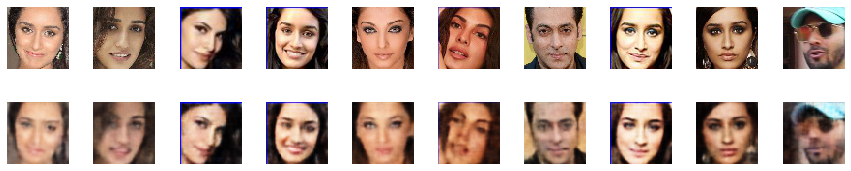

In [15]:
plot_compare_vae(images = example_images)

39 21


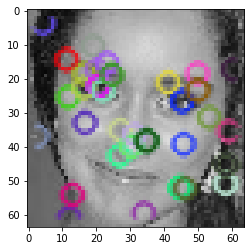

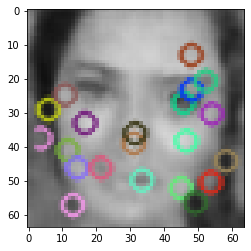

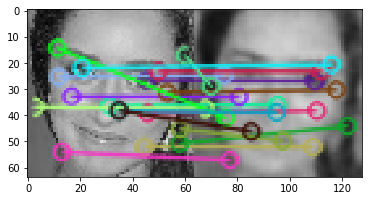

(<matplotlib.image.AxesImage at 0x27038798dc8>, None)

In [20]:
import cv2 
import matplotlib.pyplot as plt

# read images
#img11 = cv2.imread(r"C:\Users\sushilkumar.yadav\Desktop\vmware\Personal\Research\Image_recognition_in_wild_using_Deep_Learning\junichiro_koizumi.1.jpeg")
#img12 = cv2.imread(r"C:\Users\sushilkumar.yadav\Desktop\vmware\Personal\Research\Image_recognition_in_wild_using_Deep_Learning\Database_FR\New_VAE_Database\junichiro_koizumi\junichiro_koizumi.0.jpeg")

img11 = cv2.imread(r"C:\Users\sushilkumar.yadav\Desktop\vmware\Personal\Research\Image_recognition_in_wild_using_Deep_Learning\Database_FR\VAE\testmmd1.0.jpeg")
img11 = cv2.resize(img11,(64,64))
img12 = cv2.imread(r"C:\Users\sushilkumar.yadav\Desktop\vmware\Personal\Research\Image_recognition_in_wild_using_Deep_Learning\Database_FR\VAE\mmdvaegen.0.jpeg")

img1 = cv2.cvtColor(img11, cv2.COLOR_BGR2GRAY)
img2 = cv2.cvtColor(img12, cv2.COLOR_BGR2GRAY)
#sift
sift = cv2.xfeatures2d.SIFT_create()

keypoints_1, descriptors_1 = sift.detectAndCompute(img1,None)
keypoints_2, descriptors_2 = sift.detectAndCompute(img2,None)

img_1 = cv2.drawKeypoints(img1,keypoints_1,img11)
plt.figure()
plt.imshow(img_1)

img_2 = cv2.drawKeypoints(img2,keypoints_2,img12)
plt.figure()
plt.imshow(img_2)
print(len(keypoints_1), len(keypoints_2))
#feature matching
bf = cv2.BFMatcher(cv2.NORM_L1, crossCheck=True)

matches = bf.match(descriptors_1,descriptors_2)
matches = sorted(matches, key = lambda x:x.distance)

img3 = cv2.drawMatches(img1, keypoints_1, img2, keypoints_2, matches[:50], img2, flags=2)
plt.figure()
plt.imshow(img3),plt.show()

In [17]:
# for mmcd, I have refered following paper: https://link.springer.com/article/10.1007/s11063-019-10090-0
def total_loss(y_true, y_pred):
    return LOSS_FACTOR*reconstruction_loss(y_true, y_pred) + loss_mmcd
    #return LOSS_FACTOR*r_loss(y_true, y_pred) + kl_loss(y_true, y_pred)
    #return LOSS_FACTOR*reconstruction_loss(y_true, y_pred) + loss_mmd

adam_optimizer = Adam(lr = LEARNING_RATE)

vae_model.compile(optimizer=adam_optimizer, loss = total_loss, metrics = [reconstruction_loss])

checkpoint_vae = ModelCheckpoint(os.path.join(r'C:\Users\sushilkumar.yadav\Desktop\vmware\Personal\Research\Image_recognition_in_wild_using_Deep_Learning\Database_FR\VAE\weightsmmcd.h5'), save_weights_only = True, verbose=1)


vae_model.fit_generator(data_flow, 
                        shuffle=True, 
                        epochs = N_EPOCHS, 
                        initial_epoch = 0, 
                        steps_per_epoch=no_of_images / BATCH_SIZE,
                        callbacks=[checkpoint_vae])



Epoch 1/300
18/17 [===============================]- ETA: 28s - loss: 48.3476 - reconstruction_loss: 0.004 - ETA: 15s - loss: 78.0691 - reconstruction_loss: 0.007 - ETA: 11s - loss: 83.6738 - reconstruction_loss: 0.008 - ETA: 9s - loss: 82.0576 - reconstruction_loss: 0.008 - ETA: 7s - loss: 81.5823 - reconstruction_loss: 0.00 - ETA: 6s - loss: 79.4255 - reconstruction_loss: 0.00 - ETA: 5s - loss: 78.3406 - reconstruction_loss: 0.00 - ETA: 4s - loss: 76.9374 - reconstruction_loss: 0.00 - ETA: 4s - loss: 75.5540 - reconstruction_loss: 0.00 - ETA: 3s - loss: 74.6309 - reconstruction_loss: 0.00 - ETA: 2s - loss: 73.6513 - reconstruction_loss: 0.00 - ETA: 2s - loss: 72.2990 - reconstruction_loss: 0.00 - ETA: 1s - loss: 71.3303 - reconstruction_loss: 0.00 - ETA: 1s - loss: 70.6170 - reconstruction_loss: 0.00 - ETA: 0s - loss: 69.6750 - reconstruction_loss: 0.00 - ETA: 0s - loss: 68.8352 - reconstruction_loss: 0.00 - ETA: 0s - loss: 67.9735 - reconstruction_loss: 0.00 - 7s 399ms/step - loss: 


Epoch 00007: saving model to C:\Users\sushilkumar.yadav\Desktop\vmware\Personal\Research\Image_recognition_in_wild_using_Deep_Learning\Database_FR\VAE\weightsmmcd.h5
Epoch 8/300
18/17 [===============================]- ETA: 5s - loss: 49.6286 - reconstruction_loss: 0.00 - ETA: 3s - loss: 47.5321 - reconstruction_loss: 0.00 - ETA: 4s - loss: 46.7115 - reconstruction_loss: 0.00 - ETA: 4s - loss: 47.4640 - reconstruction_loss: 0.00 - ETA: 3s - loss: 47.3658 - reconstruction_loss: 0.00 - ETA: 3s - loss: 47.6740 - reconstruction_loss: 0.00 - ETA: 3s - loss: 47.6185 - reconstruction_loss: 0.00 - ETA: 3s - loss: 47.7480 - reconstruction_loss: 0.00 - ETA: 2s - loss: 47.4203 - reconstruction_loss: 0.00 - ETA: 2s - loss: 47.4651 - reconstruction_loss: 0.00 - ETA: 2s - loss: 47.7849 - reconstruction_loss: 0.00 - ETA: 1s - loss: 47.9543 - reconstruction_loss: 0.00 - ETA: 1s - loss: 47.6993 - reconstruction_loss: 0.00 - ETA: 1s - loss: 47.7760 - reconstruction_loss: 0.00 - ETA: 0s - loss: 47.5431 


Epoch 00020: saving model to C:\Users\sushilkumar.yadav\Desktop\vmware\Personal\Research\Image_recognition_in_wild_using_Deep_Learning\Database_FR\VAE\weightsmmcd.h5
Epoch 21/300
18/17 [===============================]- ETA: 5s - loss: 47.9004 - reconstruction_loss: 0.00 - ETA: 5s - loss: 49.1684 - reconstruction_loss: 0.00 - ETA: 4s - loss: 47.9251 - reconstruction_loss: 0.00 - ETA: 4s - loss: 48.0012 - reconstruction_loss: 0.00 - ETA: 4s - loss: 47.3310 - reconstruction_loss: 0.00 - ETA: 3s - loss: 47.4674 - reconstruction_loss: 0.00 - ETA: 3s - loss: 47.5391 - reconstruction_loss: 0.00 - ETA: 2s - loss: 47.3106 - reconstruction_loss: 0.00 - ETA: 2s - loss: 47.8075 - reconstruction_loss: 0.00 - ETA: 2s - loss: 47.7028 - reconstruction_loss: 0.00 - ETA: 2s - loss: 47.8006 - reconstruction_loss: 0.00 - ETA: 1s - loss: 47.8038 - reconstruction_loss: 0.00 - ETA: 1s - loss: 47.6636 - reconstruction_loss: 0.00 - ETA: 1s - loss: 47.6745 - reconstruction_loss: 0.00 - ETA: 0s - loss: 47.5311


Epoch 00033: saving model to C:\Users\sushilkumar.yadav\Desktop\vmware\Personal\Research\Image_recognition_in_wild_using_Deep_Learning\Database_FR\VAE\weightsmmcd.h5
Epoch 34/300
18/17 [===============================]- ETA: 5s - loss: 46.9016 - reconstruction_loss: 0.00 - ETA: 5s - loss: 45.3587 - reconstruction_loss: 0.00 - ETA: 4s - loss: 45.7953 - reconstruction_loss: 0.00 - ETA: 4s - loss: 45.6864 - reconstruction_loss: 0.00 - ETA: 4s - loss: 45.9578 - reconstruction_loss: 0.00 - ETA: 3s - loss: 46.0401 - reconstruction_loss: 0.00 - ETA: 3s - loss: 46.9845 - reconstruction_loss: 0.00 - ETA: 3s - loss: 46.6592 - reconstruction_loss: 0.00 - ETA: 2s - loss: 46.4853 - reconstruction_loss: 0.00 - ETA: 2s - loss: 46.0984 - reconstruction_loss: 0.00 - ETA: 2s - loss: 46.2729 - reconstruction_loss: 0.00 - ETA: 1s - loss: 46.4174 - reconstruction_loss: 0.00 - ETA: 1s - loss: 46.5154 - reconstruction_loss: 0.00 - ETA: 1s - loss: 46.5406 - reconstruction_loss: 0.00 - ETA: 0s - loss: 46.7733


Epoch 00046: saving model to C:\Users\sushilkumar.yadav\Desktop\vmware\Personal\Research\Image_recognition_in_wild_using_Deep_Learning\Database_FR\VAE\weightsmmcd.h5
Epoch 47/300
18/17 [===============================]- ETA: 5s - loss: 45.4697 - reconstruction_loss: 0.00 - ETA: 5s - loss: 47.0894 - reconstruction_loss: 0.00 - ETA: 4s - loss: 46.8053 - reconstruction_loss: 0.00 - ETA: 4s - loss: 45.9531 - reconstruction_loss: 0.00 - ETA: 3s - loss: 46.2442 - reconstruction_loss: 0.00 - ETA: 3s - loss: 45.9623 - reconstruction_loss: 0.00 - ETA: 3s - loss: 45.7467 - reconstruction_loss: 0.00 - ETA: 3s - loss: 45.8486 - reconstruction_loss: 0.00 - ETA: 2s - loss: 45.8952 - reconstruction_loss: 0.00 - ETA: 2s - loss: 46.3848 - reconstruction_loss: 0.00 - ETA: 2s - loss: 46.5022 - reconstruction_loss: 0.00 - ETA: 1s - loss: 46.3946 - reconstruction_loss: 0.00 - ETA: 1s - loss: 46.1075 - reconstruction_loss: 0.00 - ETA: 1s - loss: 46.2078 - reconstruction_loss: 0.00 - ETA: 0s - loss: 46.0919


Epoch 00059: saving model to C:\Users\sushilkumar.yadav\Desktop\vmware\Personal\Research\Image_recognition_in_wild_using_Deep_Learning\Database_FR\VAE\weightsmmcd.h5
Epoch 60/300
18/17 [===============================]- ETA: 5s - loss: 47.4452 - reconstruction_loss: 0.00 - ETA: 5s - loss: 46.0403 - reconstruction_loss: 0.00 - ETA: 4s - loss: 45.6959 - reconstruction_loss: 0.00 - ETA: 4s - loss: 45.6208 - reconstruction_loss: 0.00 - ETA: 4s - loss: 45.1555 - reconstruction_loss: 0.00 - ETA: 3s - loss: 45.0730 - reconstruction_loss: 0.00 - ETA: 3s - loss: 45.3563 - reconstruction_loss: 0.00 - ETA: 3s - loss: 45.3365 - reconstruction_loss: 0.00 - ETA: 2s - loss: 45.4871 - reconstruction_loss: 0.00 - ETA: 2s - loss: 45.5017 - reconstruction_loss: 0.00 - ETA: 2s - loss: 45.6182 - reconstruction_loss: 0.00 - ETA: 1s - loss: 45.7754 - reconstruction_loss: 0.00 - ETA: 1s - loss: 45.7132 - reconstruction_loss: 0.00 - ETA: 1s - loss: 45.6536 - reconstruction_loss: 0.00 - ETA: 0s - loss: 45.7066


Epoch 00072: saving model to C:\Users\sushilkumar.yadav\Desktop\vmware\Personal\Research\Image_recognition_in_wild_using_Deep_Learning\Database_FR\VAE\weightsmmcd.h5
Epoch 73/300
18/17 [===============================]- ETA: 5s - loss: 41.9335 - reconstruction_loss: 0.00 - ETA: 5s - loss: 44.1187 - reconstruction_loss: 0.00 - ETA: 5s - loss: 43.8544 - reconstruction_loss: 0.00 - ETA: 4s - loss: 44.3103 - reconstruction_loss: 0.00 - ETA: 4s - loss: 44.2153 - reconstruction_loss: 0.00 - ETA: 4s - loss: 43.4144 - reconstruction_loss: 0.00 - ETA: 3s - loss: 43.1578 - reconstruction_loss: 0.00 - ETA: 3s - loss: 43.6062 - reconstruction_loss: 0.00 - ETA: 2s - loss: 43.6306 - reconstruction_loss: 0.00 - ETA: 2s - loss: 43.9609 - reconstruction_loss: 0.00 - ETA: 2s - loss: 43.9781 - reconstruction_loss: 0.00 - ETA: 1s - loss: 43.9053 - reconstruction_loss: 0.00 - ETA: 1s - loss: 44.0373 - reconstruction_loss: 0.00 - ETA: 1s - loss: 44.3455 - reconstruction_loss: 0.00 - ETA: 0s - loss: 44.3697


Epoch 00085: saving model to C:\Users\sushilkumar.yadav\Desktop\vmware\Personal\Research\Image_recognition_in_wild_using_Deep_Learning\Database_FR\VAE\weightsmmcd.h5
Epoch 86/300
18/17 [===============================]- ETA: 5s - loss: 43.5864 - reconstruction_loss: 0.00 - ETA: 5s - loss: 45.0373 - reconstruction_loss: 0.00 - ETA: 4s - loss: 43.4476 - reconstruction_loss: 0.00 - ETA: 3s - loss: 42.9248 - reconstruction_loss: 0.00 - ETA: 3s - loss: 43.0375 - reconstruction_loss: 0.00 - ETA: 3s - loss: 42.9717 - reconstruction_loss: 0.00 - ETA: 3s - loss: 43.0134 - reconstruction_loss: 0.00 - ETA: 3s - loss: 42.6709 - reconstruction_loss: 0.00 - ETA: 2s - loss: 42.9424 - reconstruction_loss: 0.00 - ETA: 2s - loss: 43.2364 - reconstruction_loss: 0.00 - ETA: 2s - loss: 43.3323 - reconstruction_loss: 0.00 - ETA: 1s - loss: 43.3341 - reconstruction_loss: 0.00 - ETA: 1s - loss: 43.5797 - reconstruction_loss: 0.00 - ETA: 1s - loss: 43.7563 - reconstruction_loss: 0.00 - ETA: 0s - loss: 43.9613


Epoch 00098: saving model to C:\Users\sushilkumar.yadav\Desktop\vmware\Personal\Research\Image_recognition_in_wild_using_Deep_Learning\Database_FR\VAE\weightsmmcd.h5
Epoch 99/300
18/17 [===============================]- ETA: 5s - loss: 38.0573 - reconstruction_loss: 0.00 - ETA: 5s - loss: 40.7469 - reconstruction_loss: 0.00 - ETA: 5s - loss: 40.7569 - reconstruction_loss: 0.00 - ETA: 4s - loss: 40.9804 - reconstruction_loss: 0.00 - ETA: 4s - loss: 41.6347 - reconstruction_loss: 0.00 - ETA: 3s - loss: 42.1475 - reconstruction_loss: 0.00 - ETA: 3s - loss: 41.3612 - reconstruction_loss: 0.00 - ETA: 3s - loss: 41.4653 - reconstruction_loss: 0.00 - ETA: 2s - loss: 41.3899 - reconstruction_loss: 0.00 - ETA: 2s - loss: 41.6863 - reconstruction_loss: 0.00 - ETA: 2s - loss: 42.0318 - reconstruction_loss: 0.00 - ETA: 1s - loss: 41.9844 - reconstruction_loss: 0.00 - ETA: 1s - loss: 42.4693 - reconstruction_loss: 0.00 - ETA: 1s - loss: 42.6817 - reconstruction_loss: 0.00 - ETA: 0s - loss: 42.6997


Epoch 00111: saving model to C:\Users\sushilkumar.yadav\Desktop\vmware\Personal\Research\Image_recognition_in_wild_using_Deep_Learning\Database_FR\VAE\weightsmmcd.h5
Epoch 112/300
18/17 [===============================]- ETA: 5s - loss: 43.8268 - reconstruction_loss: 0.00 - ETA: 5s - loss: 42.4010 - reconstruction_loss: 0.00 - ETA: 4s - loss: 42.0661 - reconstruction_loss: 0.00 - ETA: 4s - loss: 41.7928 - reconstruction_loss: 0.00 - ETA: 4s - loss: 41.7642 - reconstruction_loss: 0.00 - ETA: 3s - loss: 41.3761 - reconstruction_loss: 0.00 - ETA: 3s - loss: 41.6912 - reconstruction_loss: 0.00 - ETA: 3s - loss: 41.7499 - reconstruction_loss: 0.00 - ETA: 2s - loss: 41.8950 - reconstruction_loss: 0.00 - ETA: 2s - loss: 41.9827 - reconstruction_loss: 0.00 - ETA: 2s - loss: 41.8916 - reconstruction_loss: 0.00 - ETA: 1s - loss: 42.4922 - reconstruction_loss: 0.00 - ETA: 1s - loss: 42.4522 - reconstruction_loss: 0.00 - ETA: 1s - loss: 42.2086 - reconstruction_loss: 0.00 - ETA: 0s - loss: 42.664


Epoch 00124: saving model to C:\Users\sushilkumar.yadav\Desktop\vmware\Personal\Research\Image_recognition_in_wild_using_Deep_Learning\Database_FR\VAE\weightsmmcd.h5
Epoch 125/300
18/17 [===============================]- ETA: 2s - loss: 40.6281 - reconstruction_loss: 0.00 - ETA: 3s - loss: 41.0390 - reconstruction_loss: 0.00 - ETA: 4s - loss: 41.5921 - reconstruction_loss: 0.00 - ETA: 4s - loss: 42.0263 - reconstruction_loss: 0.00 - ETA: 3s - loss: 42.9261 - reconstruction_loss: 0.00 - ETA: 3s - loss: 42.3447 - reconstruction_loss: 0.00 - ETA: 3s - loss: 42.6909 - reconstruction_loss: 0.00 - ETA: 3s - loss: 42.3134 - reconstruction_loss: 0.00 - ETA: 2s - loss: 41.9495 - reconstruction_loss: 0.00 - ETA: 2s - loss: 42.1813 - reconstruction_loss: 0.00 - ETA: 2s - loss: 41.8841 - reconstruction_loss: 0.00 - ETA: 1s - loss: 41.9669 - reconstruction_loss: 0.00 - ETA: 1s - loss: 42.0625 - reconstruction_loss: 0.00 - ETA: 1s - loss: 42.0581 - reconstruction_loss: 0.00 - ETA: 0s - loss: 41.743


Epoch 00137: saving model to C:\Users\sushilkumar.yadav\Desktop\vmware\Personal\Research\Image_recognition_in_wild_using_Deep_Learning\Database_FR\VAE\weightsmmcd.h5
Epoch 138/300
18/17 [===============================]- ETA: 5s - loss: 44.5524 - reconstruction_loss: 0.00 - ETA: 5s - loss: 42.0118 - reconstruction_loss: 0.00 - ETA: 4s - loss: 40.9120 - reconstruction_loss: 0.00 - ETA: 4s - loss: 40.4916 - reconstruction_loss: 0.00 - ETA: 4s - loss: 40.2807 - reconstruction_loss: 0.00 - ETA: 3s - loss: 41.2307 - reconstruction_loss: 0.00 - ETA: 3s - loss: 40.8207 - reconstruction_loss: 0.00 - ETA: 3s - loss: 40.5602 - reconstruction_loss: 0.00 - ETA: 2s - loss: 40.4336 - reconstruction_loss: 0.00 - ETA: 2s - loss: 40.7333 - reconstruction_loss: 0.00 - ETA: 2s - loss: 40.8628 - reconstruction_loss: 0.00 - ETA: 1s - loss: 40.6187 - reconstruction_loss: 0.00 - ETA: 1s - loss: 40.8994 - reconstruction_loss: 0.00 - ETA: 1s - loss: 41.2327 - reconstruction_loss: 0.00 - ETA: 0s - loss: 41.312


Epoch 00150: saving model to C:\Users\sushilkumar.yadav\Desktop\vmware\Personal\Research\Image_recognition_in_wild_using_Deep_Learning\Database_FR\VAE\weightsmmcd.h5
Epoch 151/300
18/17 [===============================]- ETA: 5s - loss: 43.7410 - reconstruction_loss: 0.00 - ETA: 5s - loss: 43.6528 - reconstruction_loss: 0.00 - ETA: 5s - loss: 43.8174 - reconstruction_loss: 0.00 - ETA: 4s - loss: 42.3961 - reconstruction_loss: 0.00 - ETA: 4s - loss: 41.1632 - reconstruction_loss: 0.00 - ETA: 3s - loss: 41.5076 - reconstruction_loss: 0.00 - ETA: 3s - loss: 40.8469 - reconstruction_loss: 0.00 - ETA: 3s - loss: 40.7360 - reconstruction_loss: 0.00 - ETA: 2s - loss: 40.4157 - reconstruction_loss: 0.00 - ETA: 2s - loss: 40.4869 - reconstruction_loss: 0.00 - ETA: 2s - loss: 40.6119 - reconstruction_loss: 0.00 - ETA: 1s - loss: 40.5235 - reconstruction_loss: 0.00 - ETA: 1s - loss: 40.6001 - reconstruction_loss: 0.00 - ETA: 1s - loss: 40.6025 - reconstruction_loss: 0.00 - ETA: 0s - loss: 40.515


Epoch 00163: saving model to C:\Users\sushilkumar.yadav\Desktop\vmware\Personal\Research\Image_recognition_in_wild_using_Deep_Learning\Database_FR\VAE\weightsmmcd.h5
Epoch 164/300
18/17 [===============================]- ETA: 6s - loss: 43.0888 - reconstruction_loss: 0.00 - ETA: 5s - loss: 43.1140 - reconstruction_loss: 0.00 - ETA: 4s - loss: 43.2424 - reconstruction_loss: 0.00 - ETA: 4s - loss: 42.1347 - reconstruction_loss: 0.00 - ETA: 3s - loss: 42.6744 - reconstruction_loss: 0.00 - ETA: 3s - loss: 43.4177 - reconstruction_loss: 0.00 - ETA: 3s - loss: 43.6915 - reconstruction_loss: 0.00 - ETA: 3s - loss: 43.5273 - reconstruction_loss: 0.00 - ETA: 2s - loss: 43.1850 - reconstruction_loss: 0.00 - ETA: 2s - loss: 43.3448 - reconstruction_loss: 0.00 - ETA: 2s - loss: 43.5148 - reconstruction_loss: 0.00 - ETA: 1s - loss: 43.5269 - reconstruction_loss: 0.00 - ETA: 1s - loss: 43.3533 - reconstruction_loss: 0.00 - ETA: 1s - loss: 43.1341 - reconstruction_loss: 0.00 - ETA: 0s - loss: 43.156


Epoch 00176: saving model to C:\Users\sushilkumar.yadav\Desktop\vmware\Personal\Research\Image_recognition_in_wild_using_Deep_Learning\Database_FR\VAE\weightsmmcd.h5
Epoch 177/300
18/17 [===============================]- ETA: 5s - loss: 41.5734 - reconstruction_loss: 0.00 - ETA: 5s - loss: 42.2724 - reconstruction_loss: 0.00 - ETA: 4s - loss: 42.6066 - reconstruction_loss: 0.00 - ETA: 4s - loss: 41.7062 - reconstruction_loss: 0.00 - ETA: 4s - loss: 41.3426 - reconstruction_loss: 0.00 - ETA: 3s - loss: 40.9979 - reconstruction_loss: 0.00 - ETA: 3s - loss: 40.4479 - reconstruction_loss: 0.00 - ETA: 3s - loss: 40.4348 - reconstruction_loss: 0.00 - ETA: 2s - loss: 40.1168 - reconstruction_loss: 0.00 - ETA: 2s - loss: 40.4199 - reconstruction_loss: 0.00 - ETA: 2s - loss: 40.0881 - reconstruction_loss: 0.00 - ETA: 1s - loss: 40.3332 - reconstruction_loss: 0.00 - ETA: 1s - loss: 40.2224 - reconstruction_loss: 0.00 - ETA: 1s - loss: 40.2554 - reconstruction_loss: 0.00 - ETA: 0s - loss: 40.053


Epoch 00189: saving model to C:\Users\sushilkumar.yadav\Desktop\vmware\Personal\Research\Image_recognition_in_wild_using_Deep_Learning\Database_FR\VAE\weightsmmcd.h5
Epoch 190/300
18/17 [===============================]- ETA: 4s - loss: 38.7608 - reconstruction_loss: 0.00 - ETA: 4s - loss: 41.6597 - reconstruction_loss: 0.00 - ETA: 4s - loss: 41.2798 - reconstruction_loss: 0.00 - ETA: 4s - loss: 41.2184 - reconstruction_loss: 0.00 - ETA: 4s - loss: 40.0816 - reconstruction_loss: 0.00 - ETA: 3s - loss: 39.7863 - reconstruction_loss: 0.00 - ETA: 3s - loss: 39.5954 - reconstruction_loss: 0.00 - ETA: 3s - loss: 39.4069 - reconstruction_loss: 0.00 - ETA: 2s - loss: 39.5181 - reconstruction_loss: 0.00 - ETA: 2s - loss: 39.3317 - reconstruction_loss: 0.00 - ETA: 2s - loss: 39.0990 - reconstruction_loss: 0.00 - ETA: 1s - loss: 39.1517 - reconstruction_loss: 0.00 - ETA: 1s - loss: 38.9991 - reconstruction_loss: 0.00 - ETA: 1s - loss: 39.1786 - reconstruction_loss: 0.00 - ETA: 0s - loss: 39.239


Epoch 00202: saving model to C:\Users\sushilkumar.yadav\Desktop\vmware\Personal\Research\Image_recognition_in_wild_using_Deep_Learning\Database_FR\VAE\weightsmmcd.h5
Epoch 203/300
18/17 [===============================]- ETA: 5s - loss: 41.4164 - reconstruction_loss: 0.00 - ETA: 3s - loss: 38.5010 - reconstruction_loss: 0.00 - ETA: 4s - loss: 36.9975 - reconstruction_loss: 0.00 - ETA: 4s - loss: 37.4883 - reconstruction_loss: 0.00 - ETA: 3s - loss: 37.6709 - reconstruction_loss: 0.00 - ETA: 3s - loss: 37.8406 - reconstruction_loss: 0.00 - ETA: 3s - loss: 38.0379 - reconstruction_loss: 0.00 - ETA: 3s - loss: 38.3058 - reconstruction_loss: 0.00 - ETA: 2s - loss: 38.3540 - reconstruction_loss: 0.00 - ETA: 2s - loss: 38.4880 - reconstruction_loss: 0.00 - ETA: 2s - loss: 38.4287 - reconstruction_loss: 0.00 - ETA: 1s - loss: 38.8288 - reconstruction_loss: 0.00 - ETA: 1s - loss: 38.8624 - reconstruction_loss: 0.00 - ETA: 1s - loss: 38.9886 - reconstruction_loss: 0.00 - ETA: 0s - loss: 38.975


Epoch 00215: saving model to C:\Users\sushilkumar.yadav\Desktop\vmware\Personal\Research\Image_recognition_in_wild_using_Deep_Learning\Database_FR\VAE\weightsmmcd.h5
Epoch 216/300
18/17 [===============================]- ETA: 5s - loss: 41.6146 - reconstruction_loss: 0.00 - ETA: 5s - loss: 42.2369 - reconstruction_loss: 0.00 - ETA: 4s - loss: 42.1360 - reconstruction_loss: 0.00 - ETA: 4s - loss: 41.6034 - reconstruction_loss: 0.00 - ETA: 4s - loss: 41.0841 - reconstruction_loss: 0.00 - ETA: 3s - loss: 40.4999 - reconstruction_loss: 0.00 - ETA: 3s - loss: 40.0173 - reconstruction_loss: 0.00 - ETA: 3s - loss: 39.5511 - reconstruction_loss: 0.00 - ETA: 2s - loss: 39.2991 - reconstruction_loss: 0.00 - ETA: 2s - loss: 39.2449 - reconstruction_loss: 0.00 - ETA: 2s - loss: 39.2638 - reconstruction_loss: 0.00 - ETA: 1s - loss: 38.9687 - reconstruction_loss: 0.00 - ETA: 1s - loss: 39.0113 - reconstruction_loss: 0.00 - ETA: 1s - loss: 39.0184 - reconstruction_loss: 0.00 - ETA: 0s - loss: 38.921


Epoch 00228: saving model to C:\Users\sushilkumar.yadav\Desktop\vmware\Personal\Research\Image_recognition_in_wild_using_Deep_Learning\Database_FR\VAE\weightsmmcd.h5
Epoch 229/300
18/17 [===============================]- ETA: 5s - loss: 35.5786 - reconstruction_loss: 0.00 - ETA: 5s - loss: 36.3150 - reconstruction_loss: 0.00 - ETA: 4s - loss: 37.9397 - reconstruction_loss: 0.00 - ETA: 4s - loss: 37.7930 - reconstruction_loss: 0.00 - ETA: 4s - loss: 38.4137 - reconstruction_loss: 0.00 - ETA: 3s - loss: 38.2808 - reconstruction_loss: 0.00 - ETA: 3s - loss: 38.0649 - reconstruction_loss: 0.00 - ETA: 3s - loss: 37.7485 - reconstruction_loss: 0.00 - ETA: 2s - loss: 38.2873 - reconstruction_loss: 0.00 - ETA: 2s - loss: 38.6700 - reconstruction_loss: 0.00 - ETA: 2s - loss: 38.6353 - reconstruction_loss: 0.00 - ETA: 1s - loss: 38.7486 - reconstruction_loss: 0.00 - ETA: 1s - loss: 38.2533 - reconstruction_loss: 0.00 - ETA: 1s - loss: 38.2659 - reconstruction_loss: 0.00 - ETA: 0s - loss: 38.325


Epoch 00241: saving model to C:\Users\sushilkumar.yadav\Desktop\vmware\Personal\Research\Image_recognition_in_wild_using_Deep_Learning\Database_FR\VAE\weightsmmcd.h5
Epoch 242/300
18/17 [===============================]- ETA: 5s - loss: 37.5649 - reconstruction_loss: 0.00 - ETA: 5s - loss: 37.8414 - reconstruction_loss: 0.00 - ETA: 5s - loss: 36.7959 - reconstruction_loss: 0.00 - ETA: 4s - loss: 36.7404 - reconstruction_loss: 0.00 - ETA: 4s - loss: 37.8266 - reconstruction_loss: 0.00 - ETA: 4s - loss: 37.5382 - reconstruction_loss: 0.00 - ETA: 3s - loss: 37.5734 - reconstruction_loss: 0.00 - ETA: 3s - loss: 37.4043 - reconstruction_loss: 0.00 - ETA: 2s - loss: 38.2690 - reconstruction_loss: 0.00 - ETA: 2s - loss: 38.5698 - reconstruction_loss: 0.00 - ETA: 2s - loss: 38.4109 - reconstruction_loss: 0.00 - ETA: 1s - loss: 38.3914 - reconstruction_loss: 0.00 - ETA: 1s - loss: 38.6207 - reconstruction_loss: 0.00 - ETA: 1s - loss: 38.4776 - reconstruction_loss: 0.00 - ETA: 0s - loss: 38.588


Epoch 00254: saving model to C:\Users\sushilkumar.yadav\Desktop\vmware\Personal\Research\Image_recognition_in_wild_using_Deep_Learning\Database_FR\VAE\weightsmmcd.h5
Epoch 255/300
18/17 [===============================]- ETA: 5s - loss: 37.1622 - reconstruction_loss: 0.00 - ETA: 5s - loss: 38.6801 - reconstruction_loss: 0.00 - ETA: 5s - loss: 38.7121 - reconstruction_loss: 0.00 - ETA: 4s - loss: 39.0911 - reconstruction_loss: 0.00 - ETA: 4s - loss: 38.9911 - reconstruction_loss: 0.00 - ETA: 4s - loss: 38.8547 - reconstruction_loss: 0.00 - ETA: 3s - loss: 39.0590 - reconstruction_loss: 0.00 - ETA: 3s - loss: 39.0949 - reconstruction_loss: 0.00 - ETA: 3s - loss: 38.9985 - reconstruction_loss: 0.00 - ETA: 2s - loss: 38.7690 - reconstruction_loss: 0.00 - ETA: 2s - loss: 38.6364 - reconstruction_loss: 0.00 - ETA: 1s - loss: 38.3212 - reconstruction_loss: 0.00 - ETA: 1s - loss: 38.4188 - reconstruction_loss: 0.00 - ETA: 1s - loss: 38.4661 - reconstruction_loss: 0.00 - ETA: 0s - loss: 38.431


Epoch 00267: saving model to C:\Users\sushilkumar.yadav\Desktop\vmware\Personal\Research\Image_recognition_in_wild_using_Deep_Learning\Database_FR\VAE\weightsmmcd.h5
Epoch 268/300
18/17 [===============================]- ETA: 5s - loss: 38.8110 - reconstruction_loss: 0.00 - ETA: 5s - loss: 37.7344 - reconstruction_loss: 0.00 - ETA: 4s - loss: 37.1558 - reconstruction_loss: 0.00 - ETA: 4s - loss: 37.5558 - reconstruction_loss: 0.00 - ETA: 4s - loss: 37.4071 - reconstruction_loss: 0.00 - ETA: 3s - loss: 37.4773 - reconstruction_loss: 0.00 - ETA: 3s - loss: 37.9955 - reconstruction_loss: 0.00 - ETA: 3s - loss: 38.1877 - reconstruction_loss: 0.00 - ETA: 2s - loss: 38.1788 - reconstruction_loss: 0.00 - ETA: 2s - loss: 37.8018 - reconstruction_loss: 0.00 - ETA: 2s - loss: 38.1234 - reconstruction_loss: 0.00 - ETA: 1s - loss: 37.9578 - reconstruction_loss: 0.00 - ETA: 1s - loss: 38.3687 - reconstruction_loss: 0.00 - ETA: 1s - loss: 38.4236 - reconstruction_loss: 0.00 - ETA: 0s - loss: 38.363


Epoch 00280: saving model to C:\Users\sushilkumar.yadav\Desktop\vmware\Personal\Research\Image_recognition_in_wild_using_Deep_Learning\Database_FR\VAE\weightsmmcd.h5
Epoch 281/300
18/17 [===============================]- ETA: 5s - loss: 39.7774 - reconstruction_loss: 0.00 - ETA: 5s - loss: 39.1118 - reconstruction_loss: 0.00 - ETA: 4s - loss: 39.2084 - reconstruction_loss: 0.00 - ETA: 4s - loss: 39.2564 - reconstruction_loss: 0.00 - ETA: 4s - loss: 38.5797 - reconstruction_loss: 0.00 - ETA: 3s - loss: 38.0515 - reconstruction_loss: 0.00 - ETA: 3s - loss: 38.0098 - reconstruction_loss: 0.00 - ETA: 2s - loss: 37.8057 - reconstruction_loss: 0.00 - ETA: 2s - loss: 37.7153 - reconstruction_loss: 0.00 - ETA: 2s - loss: 37.7406 - reconstruction_loss: 0.00 - ETA: 2s - loss: 37.8024 - reconstruction_loss: 0.00 - ETA: 1s - loss: 37.9450 - reconstruction_loss: 0.00 - ETA: 1s - loss: 37.7788 - reconstruction_loss: 0.00 - ETA: 1s - loss: 37.7179 - reconstruction_loss: 0.00 - ETA: 0s - loss: 37.848


Epoch 00293: saving model to C:\Users\sushilkumar.yadav\Desktop\vmware\Personal\Research\Image_recognition_in_wild_using_Deep_Learning\Database_FR\VAE\weightsmmcd.h5
Epoch 294/300
18/17 [===============================]- ETA: 5s - loss: 39.2463 - reconstruction_loss: 0.00 - ETA: 5s - loss: 37.3861 - reconstruction_loss: 0.00 - ETA: 4s - loss: 39.4022 - reconstruction_loss: 0.00 - ETA: 4s - loss: 39.0427 - reconstruction_loss: 0.00 - ETA: 4s - loss: 38.9588 - reconstruction_loss: 0.00 - ETA: 3s - loss: 39.4150 - reconstruction_loss: 0.00 - ETA: 3s - loss: 38.9403 - reconstruction_loss: 0.00 - ETA: 3s - loss: 39.0569 - reconstruction_loss: 0.00 - ETA: 2s - loss: 38.6825 - reconstruction_loss: 0.00 - ETA: 2s - loss: 38.6862 - reconstruction_loss: 0.00 - ETA: 2s - loss: 38.6337 - reconstruction_loss: 0.00 - ETA: 1s - loss: 38.4830 - reconstruction_loss: 0.00 - ETA: 1s - loss: 38.5242 - reconstruction_loss: 0.00 - ETA: 1s - loss: 38.5501 - reconstruction_loss: 0.00 - ETA: 0s - loss: 38.553

In [18]:
def plot_compare_vae(images=None):
  
  if images is None:
    example_batch = next(data_flow)
    example_batch = example_batch[0]
    images = example_batch[:10]

  n_to_show = images.shape[0]
  reconst_images = vae_model.predict(images)

  fig = plt.figure(figsize=(15, 3))
  fig.subplots_adjust(hspace=0.4, wspace=0.4)

  for i in range(n_to_show):
      img = images[i].squeeze()
      sub = fig.add_subplot(2, n_to_show, i+1)
      sub.axis('off')        
      sub.imshow(img)
      cv2.imwrite(r"C:\Users\sushilkumar.yadav\Desktop\vmware\Personal\Research\Image_recognition_in_wild_using_Deep_Learning\Database_FR\VAE\testmmcd1."+ str(i)+".jpeg", 255*img)

  for i in range(n_to_show):
      img = reconst_images[i].squeeze()
      sub = fig.add_subplot(2, n_to_show, i+n_to_show+1)
      sub.axis('off')
      sub.imshow(img)
      cv2.imwrite(r"C:\Users\sushilkumar.yadav\Desktop\vmware\Personal\Research\Image_recognition_in_wild_using_Deep_Learning\Database_FR\VAE\mmcdvaegen."+ str(i)+".jpeg", 255*img)
      


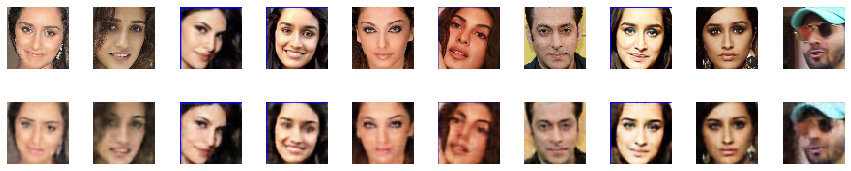

In [19]:
plot_compare_vae(images = example_images)

39 44


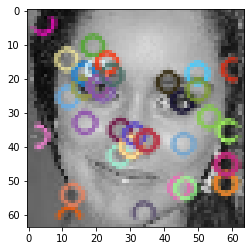

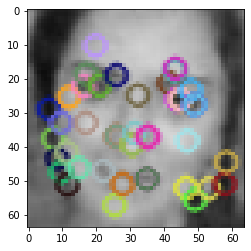

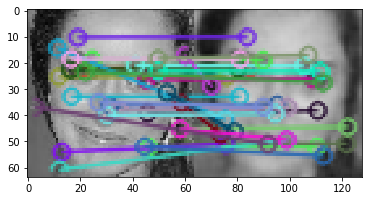

(<matplotlib.image.AxesImage at 0x2703819ec08>, None)

In [21]:
import cv2 
import matplotlib.pyplot as plt

# read images
#img11 = cv2.imread(r"C:\Users\sushilkumar.yadav\Desktop\vmware\Personal\Research\Image_recognition_in_wild_using_Deep_Learning\junichiro_koizumi.1.jpeg")
#img12 = cv2.imread(r"C:\Users\sushilkumar.yadav\Desktop\vmware\Personal\Research\Image_recognition_in_wild_using_Deep_Learning\Database_FR\New_VAE_Database\junichiro_koizumi\junichiro_koizumi.0.jpeg")

img11 = cv2.imread(r"C:\Users\sushilkumar.yadav\Desktop\vmware\Personal\Research\Image_recognition_in_wild_using_Deep_Learning\Database_FR\VAE\testmmcd1.0.jpeg")
img11 = cv2.resize(img11,(64,64))
img12 = cv2.imread(r"C:\Users\sushilkumar.yadav\Desktop\vmware\Personal\Research\Image_recognition_in_wild_using_Deep_Learning\Database_FR\VAE\mmcdvaegen.0.jpeg")

img1 = cv2.cvtColor(img11, cv2.COLOR_BGR2GRAY)
img2 = cv2.cvtColor(img12, cv2.COLOR_BGR2GRAY)
#sift
sift = cv2.xfeatures2d.SIFT_create()

keypoints_1, descriptors_1 = sift.detectAndCompute(img1,None)
keypoints_2, descriptors_2 = sift.detectAndCompute(img2,None)

img_1 = cv2.drawKeypoints(img1,keypoints_1,img11)
plt.figure()
plt.imshow(img_1)

img_2 = cv2.drawKeypoints(img2,keypoints_2,img12)
plt.figure()
plt.imshow(img_2)
print(len(keypoints_1), len(keypoints_2))
#feature matching
bf = cv2.BFMatcher(cv2.NORM_L1, crossCheck=True)

matches = bf.match(descriptors_1,descriptors_2)
matches = sorted(matches, key = lambda x:x.distance)

img3 = cv2.drawMatches(img1, keypoints_1, img2, keypoints_2, matches[:50], img2, flags=2)
plt.figure()
plt.imshow(img3),plt.show()

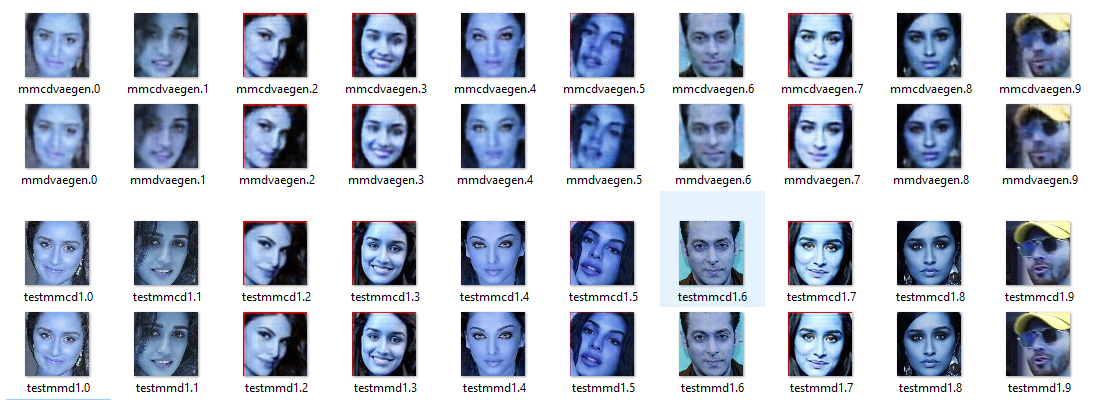

In [23]:
#from the following result we could see that mmcd image are little bit much clearer than mmd reconstructed
#also reconstruction loss is lower in mmcd as compared to mmd
from IPython.display import Image
Image(filename=r'C:\Users\sushilkumar.yadav\Desktop\original_mmd_mmcd_compare.png')

VAE does not works well when we use it for multi class image reconstruction
when used 
def total_loss(y_true, y_pred):
    return LOSS_FACTOR*reconstruction_loss(y_true, y_pred) + kl_loss(y_true, y_pred)

we are getting the following results

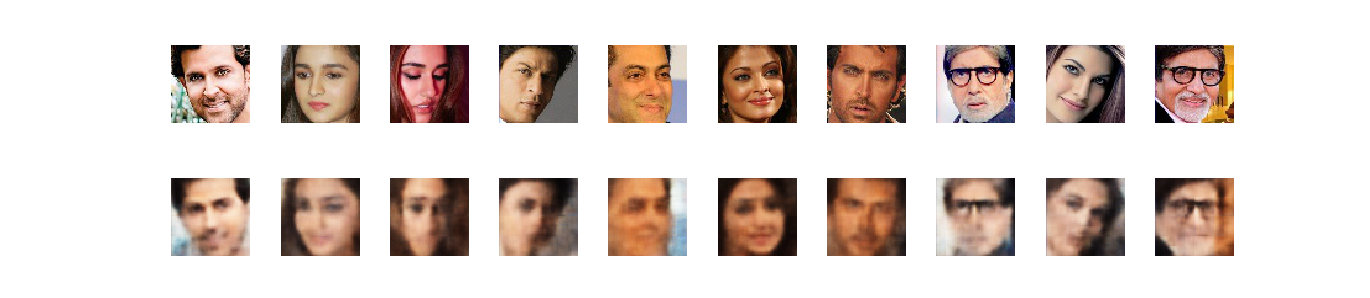

In [32]:
from IPython.display import Image
Image(filename=r'C:\Users\sushilkumar.yadav\Desktop\vae_kl_loss.png')

41 20


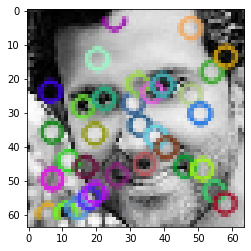

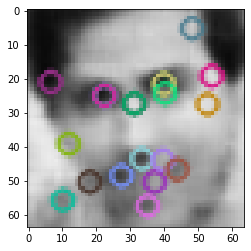

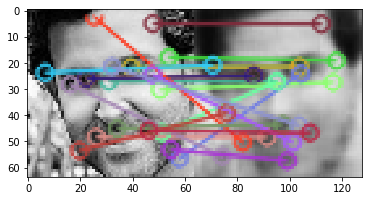

(<matplotlib.image.AxesImage at 0x254213c8088>, None)

In [35]:
#SIFT Plot on test samples for VAE using KL Loss...
import cv2 
import matplotlib.pyplot as plt

# read images
#img11 = cv2.imread(r"C:\Users\sushilkumar.yadav\Desktop\vmware\Personal\Research\Image_recognition_in_wild_using_Deep_Learning\junichiro_koizumi.1.jpeg")
#img12 = cv2.imread(r"C:\Users\sushilkumar.yadav\Desktop\vmware\Personal\Research\Image_recognition_in_wild_using_Deep_Learning\Database_FR\New_VAE_Database\junichiro_koizumi\junichiro_koizumi.0.jpeg")

img11 = cv2.imread(r"C:\Users\sushilkumar.yadav\Desktop\vmware\Personal\Research\Image_recognition_in_wild_using_Deep_Learning\Database_FR\VAE\test1.0.jpeg")
img11 = cv2.resize(img11,(64,64))
img12 = cv2.imread(r"C:\Users\sushilkumar.yadav\Desktop\vmware\Personal\Research\Image_recognition_in_wild_using_Deep_Learning\Database_FR\VAE\vaegen.0.jpeg")

img1 = cv2.cvtColor(img11, cv2.COLOR_BGR2GRAY)
img2 = cv2.cvtColor(img12, cv2.COLOR_BGR2GRAY)
#sift
sift = cv2.xfeatures2d.SIFT_create()

keypoints_1, descriptors_1 = sift.detectAndCompute(img1,None)
keypoints_2, descriptors_2 = sift.detectAndCompute(img2,None)

img_1 = cv2.drawKeypoints(img1,keypoints_1,img11)
plt.figure()
plt.imshow(img_1)

img_2 = cv2.drawKeypoints(img2,keypoints_2,img12)
plt.figure()
plt.imshow(img_2)
print(len(keypoints_1), len(keypoints_2))
#feature matching
bf = cv2.BFMatcher(cv2.NORM_L1, crossCheck=True)

matches = bf.match(descriptors_1,descriptors_2)
matches = sorted(matches, key = lambda x:x.distance)

img3 = cv2.drawMatches(img1, keypoints_1, img2, keypoints_2, matches[:50], img2, flags=2)
plt.figure()
plt.imshow(img3),plt.show()

In [1]:
def total_loss(y_true, y_pred):
    return LOSS_FACTOR*reconstruction_loss(y_true, y_pred) + kl_loss(y_true, y_pred)
    #return LOSS_FACTOR*r_loss(y_true, y_pred) + kl_loss(y_true, y_pred)
    #return LOSS_FACTOR*reconstruction_loss(y_true, y_pred) + loss_mmd

adam_optimizer = Adam(lr = LEARNING_RATE)

vae_model.compile(optimizer=adam_optimizer, loss = total_loss, metrics = [reconstruction_loss])

checkpoint_vae = ModelCheckpoint(os.path.join(r'C:\Users\sushilkumar.yadav\Desktop\vmware\Personal\Research\Image_recognition_in_wild_using_Deep_Learning\Database_FR\VAE\weightselbo.h5'), save_weights_only = True, verbose=1)


vae_model.fit_generator(data_flow, 
                        shuffle=True, 
                        epochs = N_EPOCHS, 
                        initial_epoch = 0, 
                        steps_per_epoch=no_of_images / BATCH_SIZE,
                        callbacks=[checkpoint_vae])


NameError: name 'Adam' is not defined